In [2]:
import deepchem as dc
import pandas as pd
import numpy as np
from rdkit import Chem

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,KFold

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

from sklearn.metrics import recall_score

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 300

import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [3]:
import shap
shap.initjs()

In [4]:
data = pd.read_csv('../../data/GABAA.csv',encoding='gb18030')

# Feature extraction & Data splitting

In [5]:
featurizer = dc.feat.MACCSKeysFingerprint()
features = featurizer.featurize(data['smiles'])

In [6]:
from sklearn.feature_selection import VarianceThreshold


vt = VarianceThreshold(threshold = (.98 * (1 - .98)))


X_new = vt.fit_transform(features)
dataset = dc.data.NumpyDataset(X_new,data['class'])

In [7]:
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=100)

In [8]:
data_maccs_mask = vt.get_support(indices=True)

# t-SNE

<Axes: >

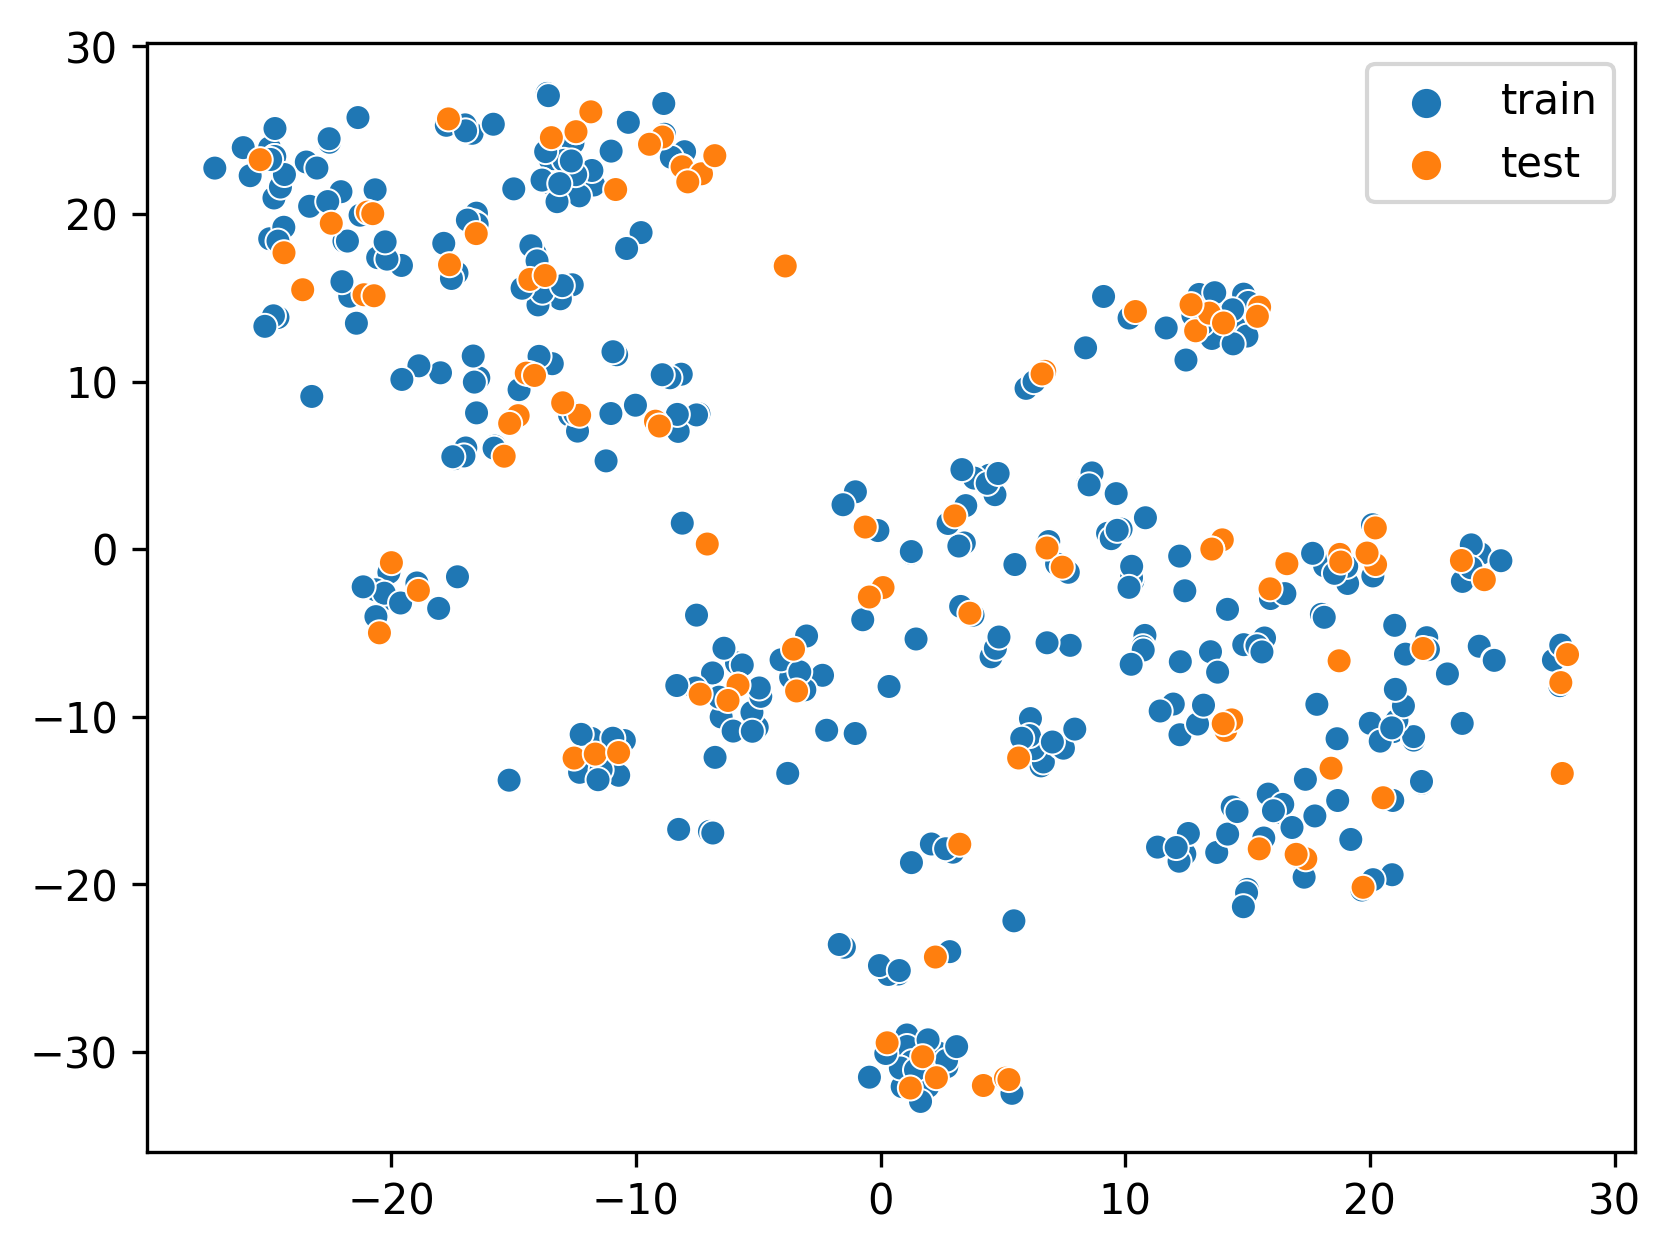

In [10]:
data_MACCSkeys = np.concatenate((train_dataset.X, test_dataset.X), axis=0)


tsne = TSNE(n_components=2,random_state=42)
transformed_data = tsne.fit_transform(data_MACCSkeys)


sns.scatterplot(x=transformed_data[:, 0], y=transformed_data[:, 1], hue=['train']*390 + ['test']*98)

# GridSearchCV

In [11]:
scoring = {
         'AUC':make_scorer(roc_auc_score, needs_proba=True),
          'ACC':make_scorer(accuracy_score),
           'PRE':make_scorer(precision_score),
           'REC':make_scorer(recall_score),
}

classifier  =  RandomForestClassifier(random_state=42)

rf_param_grid = {'n_estimators':[40,60,80,100,120,140],
              'max_depth':[5,8,10,20,30,40],
            'max_features':["auto", "sqrt", "log2"]}


rf_gs = GridSearchCV(
                    classifier,
                   rf_param_grid,
                 scoring = scoring,
                  cv = KFold(n_splits=5, shuffle=True, random_state=100),
                 n_jobs = -1,
               refit = 'AUC',
               return_train_score = True)

rf_gs_fit = rf_gs.fit(train_dataset.X, train_dataset.y.ravel())

In [12]:
val_AUC = rf_gs.best_score_
val_ACC = rf_gs.cv_results_['mean_test_ACC'][rf_gs.best_index_]
val_PRE = rf_gs.cv_results_['mean_test_PRE'][rf_gs.best_index_]
val_REC = rf_gs.cv_results_['mean_test_REC'][rf_gs.best_index_]

In [13]:
print('Best parameters: ', rf_gs.best_params_)
print('Best score (AUC): ', rf_gs.best_score_)
print('ACC: ', rf_gs.cv_results_['mean_test_ACC'][rf_gs.best_index_])
print('PRE: ', rf_gs.cv_results_['mean_test_PRE'][rf_gs.best_index_])
print('REC: ',rf_gs.cv_results_['mean_test_REC'][rf_gs.best_index_])

Best parameters:  {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 60}
Best score (AUC):  0.9476258733694738
ACC:  0.8794871794871796
PRE:  0.86999180999181
REC:  0.891042932885038


In [14]:
rf_model = rf_gs_fit.best_estimator_
rf_model

RandomForestClassifier(max_depth=8, n_estimators=60, random_state=42)

# Model evaluation

In [15]:
y_test_pred_proba = rf_model.predict_proba(test_dataset.X)
y_test_pred = rf_model.predict(test_dataset.X)

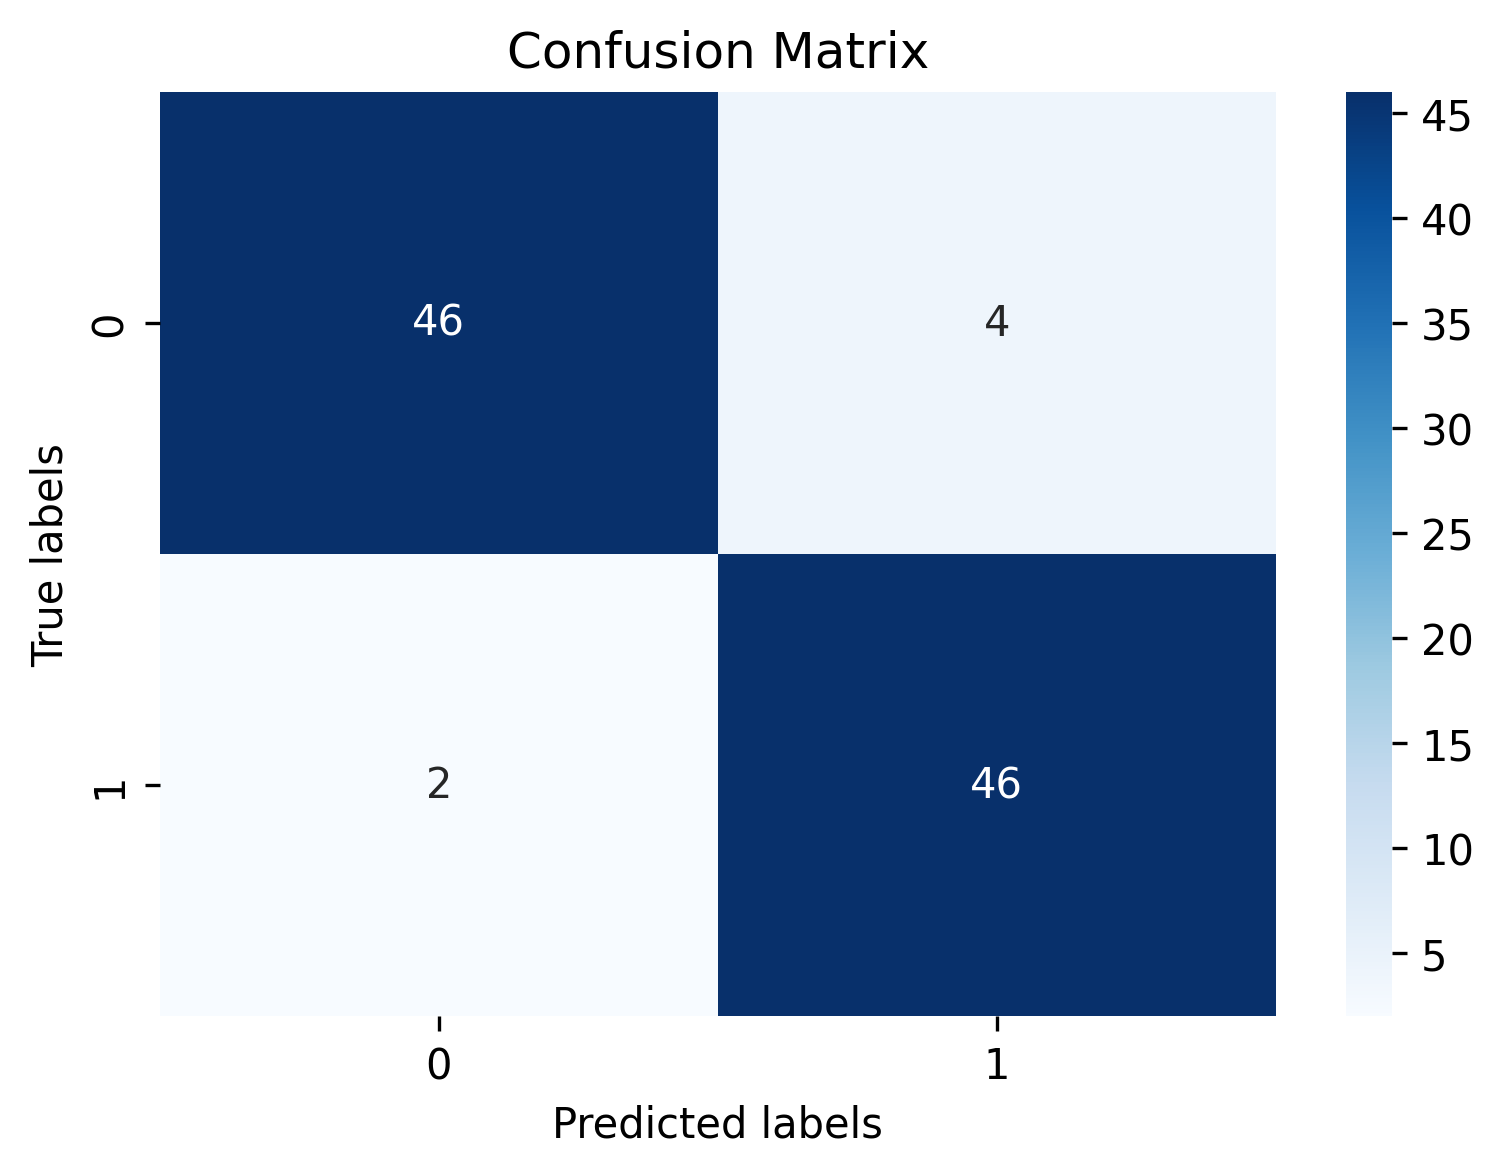

In [13]:
confusion_mat = confusion_matrix(test_dataset.y, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [14]:
rf_test_pred_list = []
for test_score in y_test_pred_proba:
    test_score = test_score[1]
    rf_test_pred_list.append(test_score)

In [15]:
rf_test_pred_array = np.array(rf_test_pred_list)

In [17]:
test_AUC = roc_auc_score(test_dataset.y,rf_test_pred_list)
test_ACC = accuracy_score(test_dataset.y,np.round(rf_test_pred_array))
test_PRE = precision_score(test_dataset.y,np.round(rf_test_pred_array))
test_REC = recall_score(test_dataset.y,np.round(rf_test_pred_array))

In [18]:
rf_performance_dataset = {
    'AUC':[val_AUC,test_AUC],
    'ACC':[val_ACC,test_ACC],
    'PRE':[val_PRE,test_PRE],
    'REC':[val_REC,test_REC]
}

In [19]:
rf_performance = pd.DataFrame(rf_performance_dataset,index=['val','test'])
rf_performance

AUC       ACC       PRE       REC
val   0.947626  0.879487  0.869992  0.891043
test  0.987500  0.938776  0.920000  0.958333

In [12]:
import pickle

with open('rf_maccs_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

In [22]:
my_array = np.array([True, False], dtype=np.bool_)
my_variable = True

# Ave_confusion_matrix

In [23]:
#the average of five different random seeds
confusion_mat_ave = np.array([[42.4,8],
                        [5.4,45.4]])

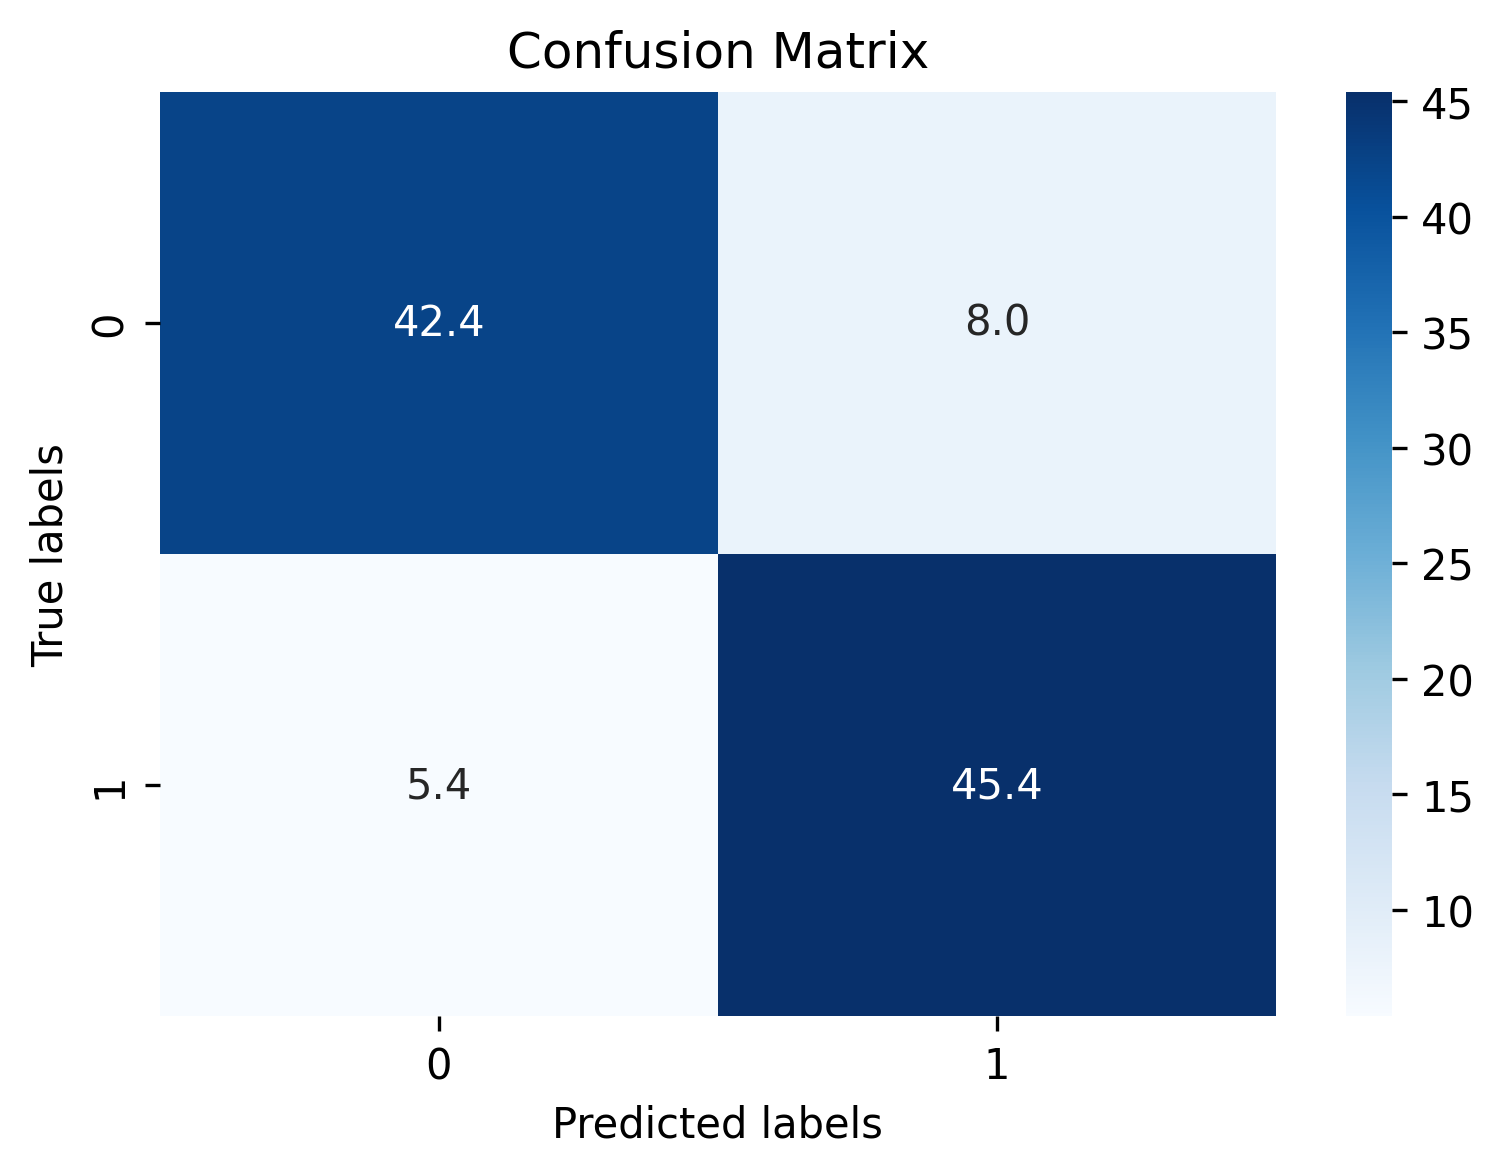

In [24]:

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat_ave, annot=True, fmt=".1f", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# SHAP

In [16]:
MACCS = pd.read_csv('../../data/MACCS.csv',encoding='gb18030')
result = [MACCS['REMARK'][i-1] for i in data_maccs_mask]

In [17]:
explainer = shap.TreeExplainer(rf_model,
                               feature_names=result) 
shap_values = explainer.shap_values(test_dataset.X)

In [18]:
test_data = pd.DataFrame(test_dataset.X, columns=result)

<Figure size 3600x2400 with 0 Axes>

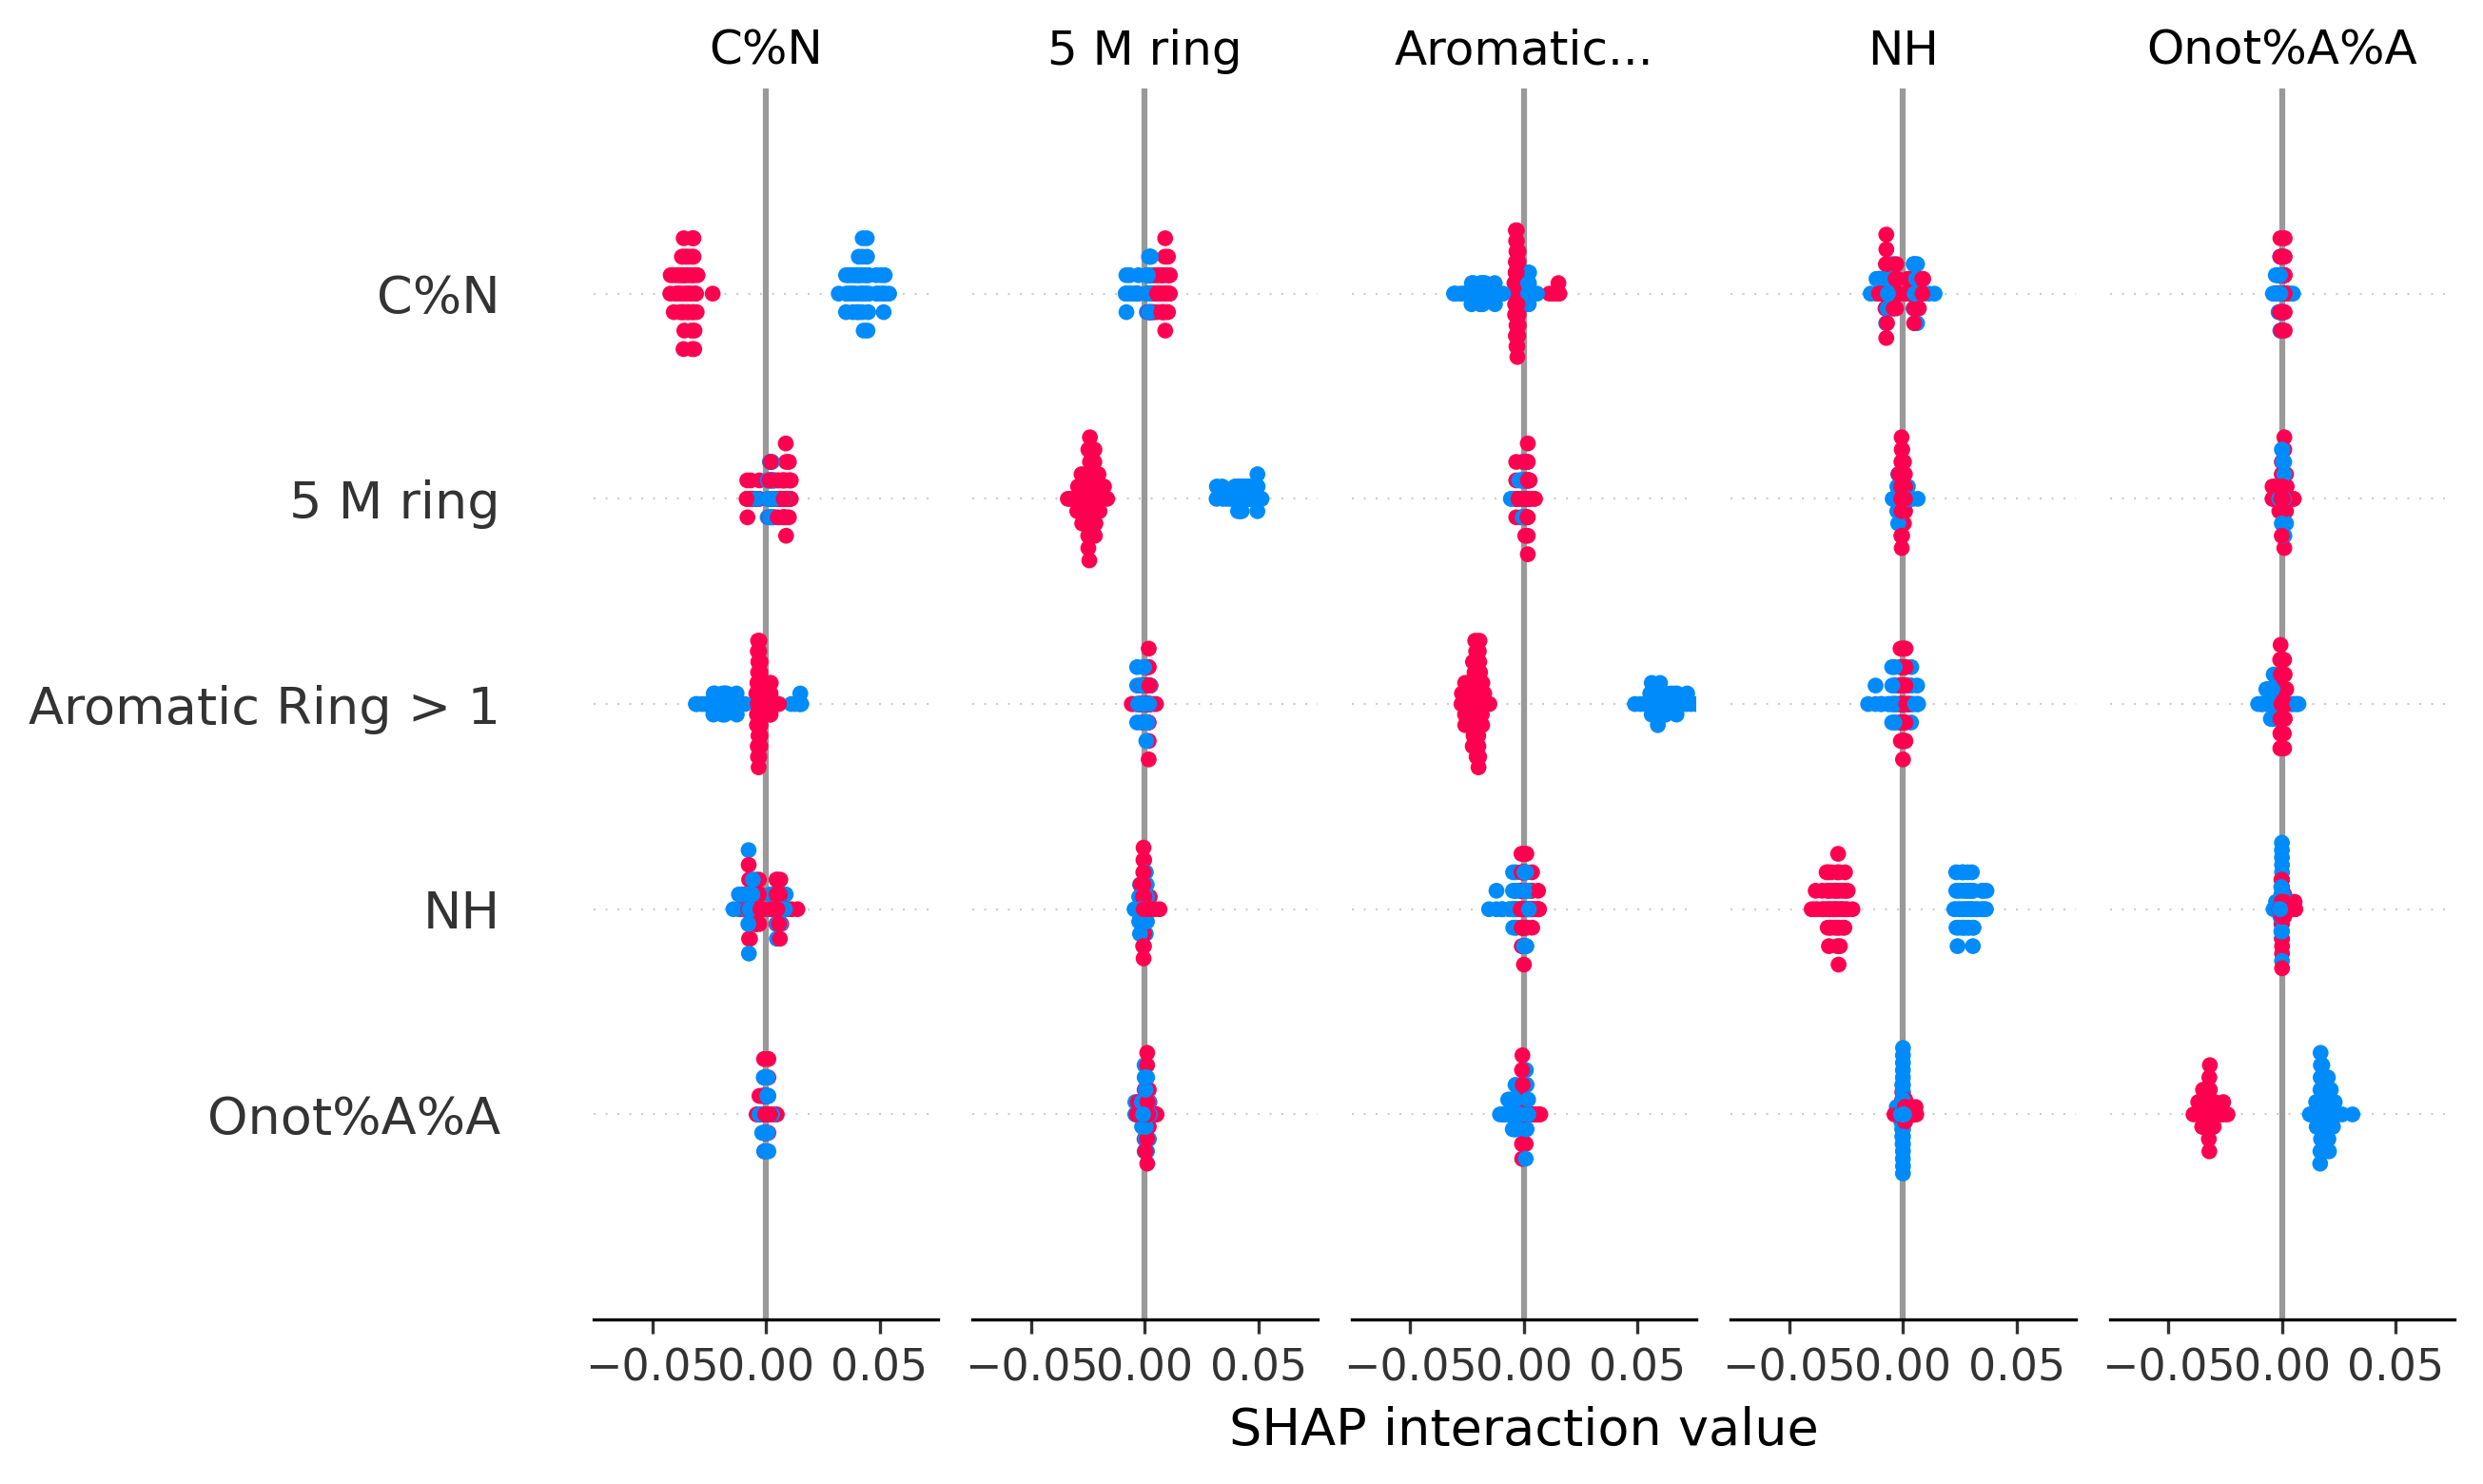

In [21]:
plt.figure(figsize=(12, 8)) 
shap_interaction_values = explainer.shap_interaction_values(test_dataset.X)
shap.summary_plot(shap_interaction_values[1],test_data, max_display=5,show=False)

plt.show()

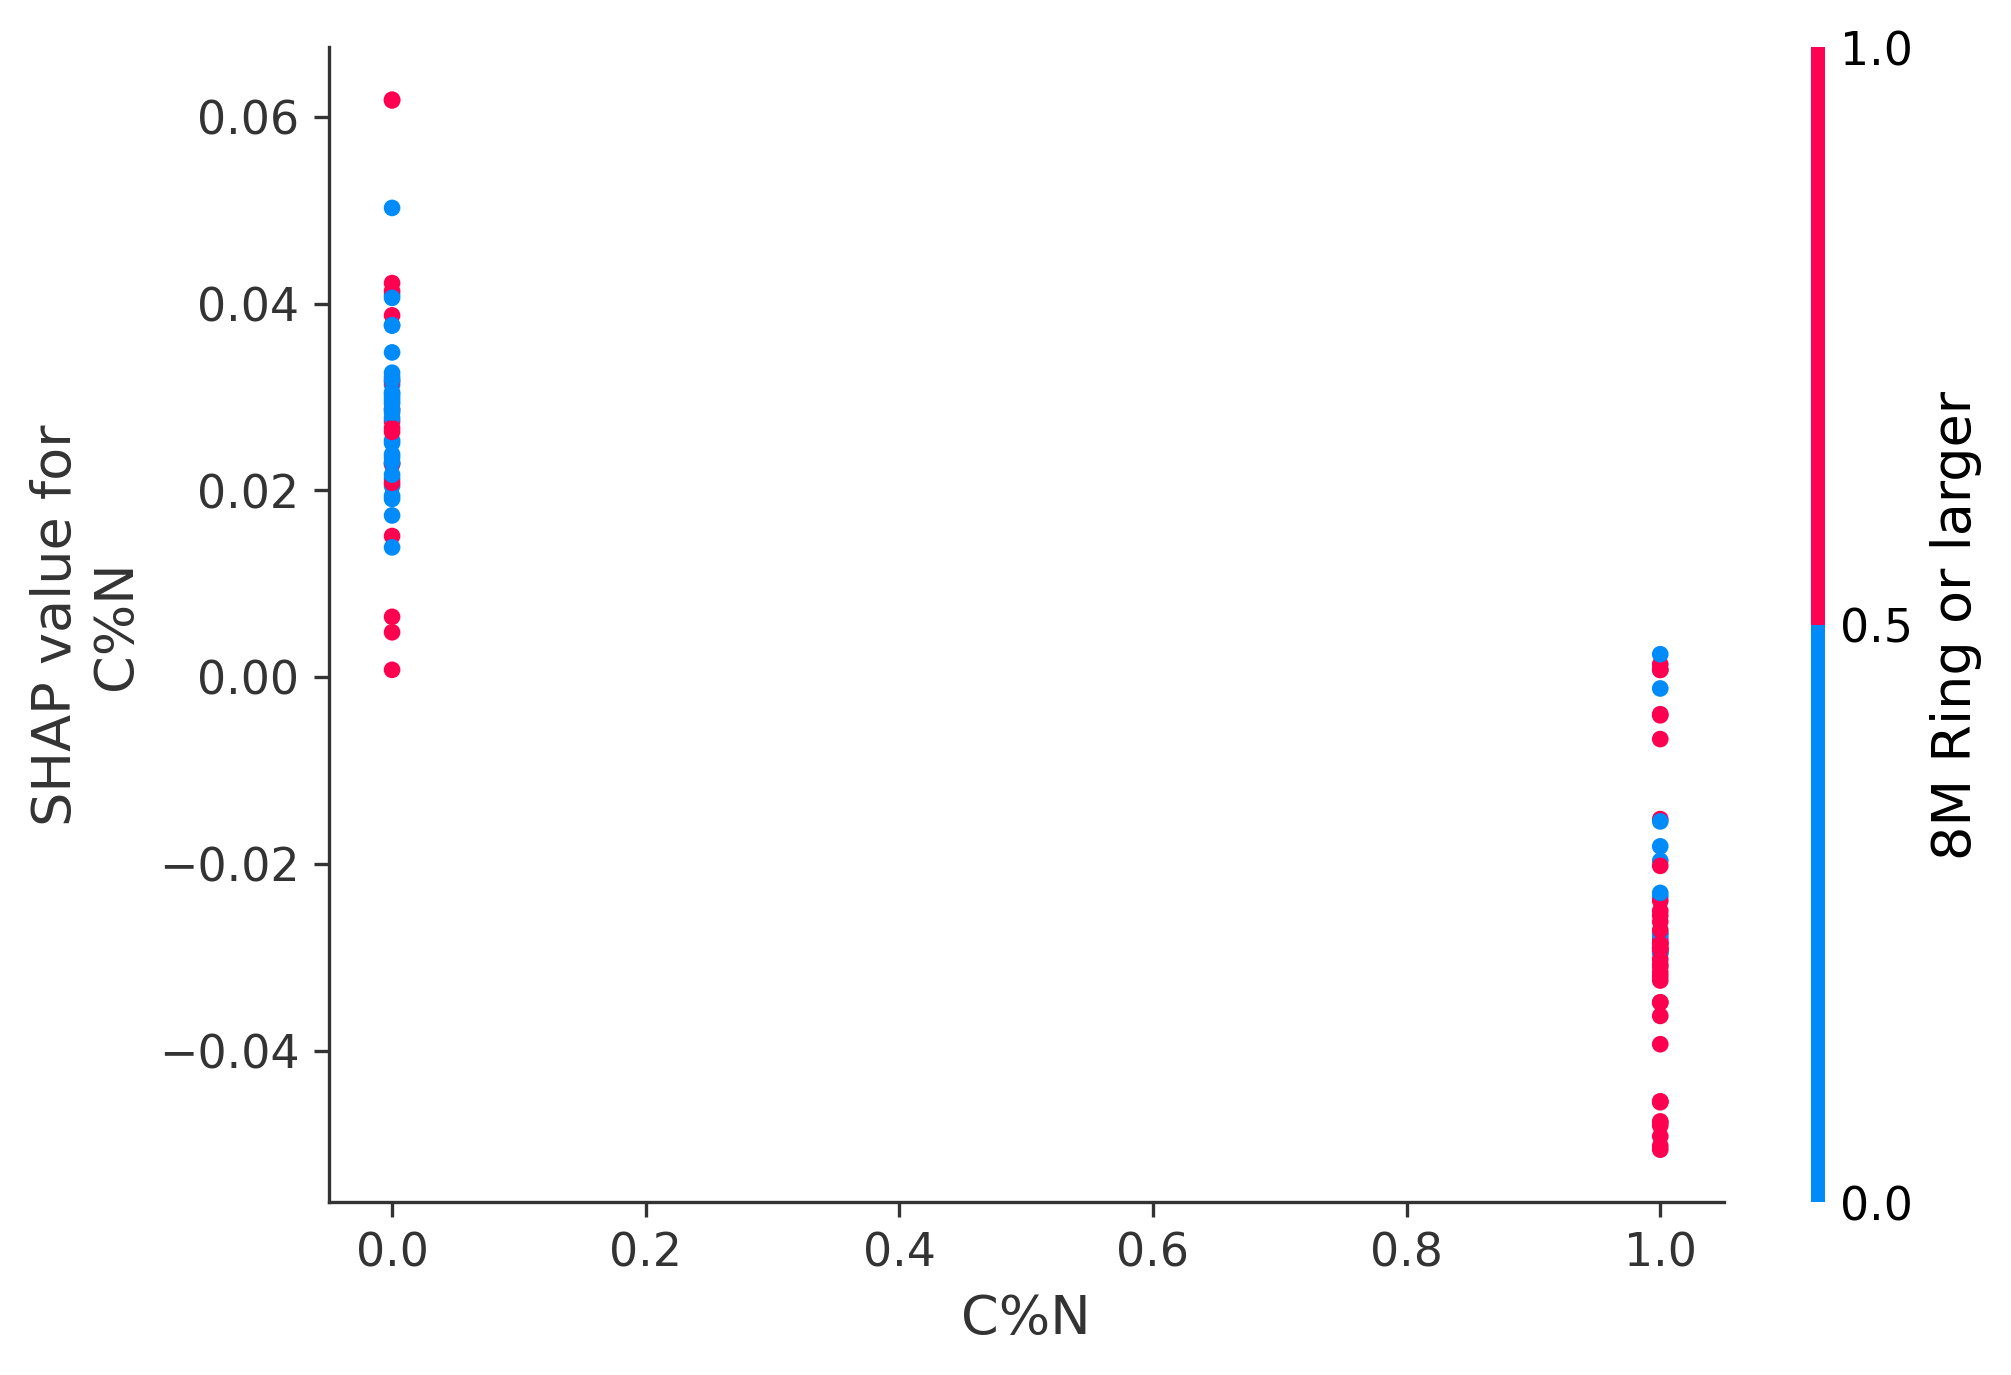

In [24]:
#shap.dependence_plot("8M Ring or larger",shap_values[1], test_dataset.X,feature_names=result,display_features=test_dataset.X)
shap.dependence_plot("C%N",shap_values[1], test_dataset.X,feature_names=result,display_features=test_dataset.X)

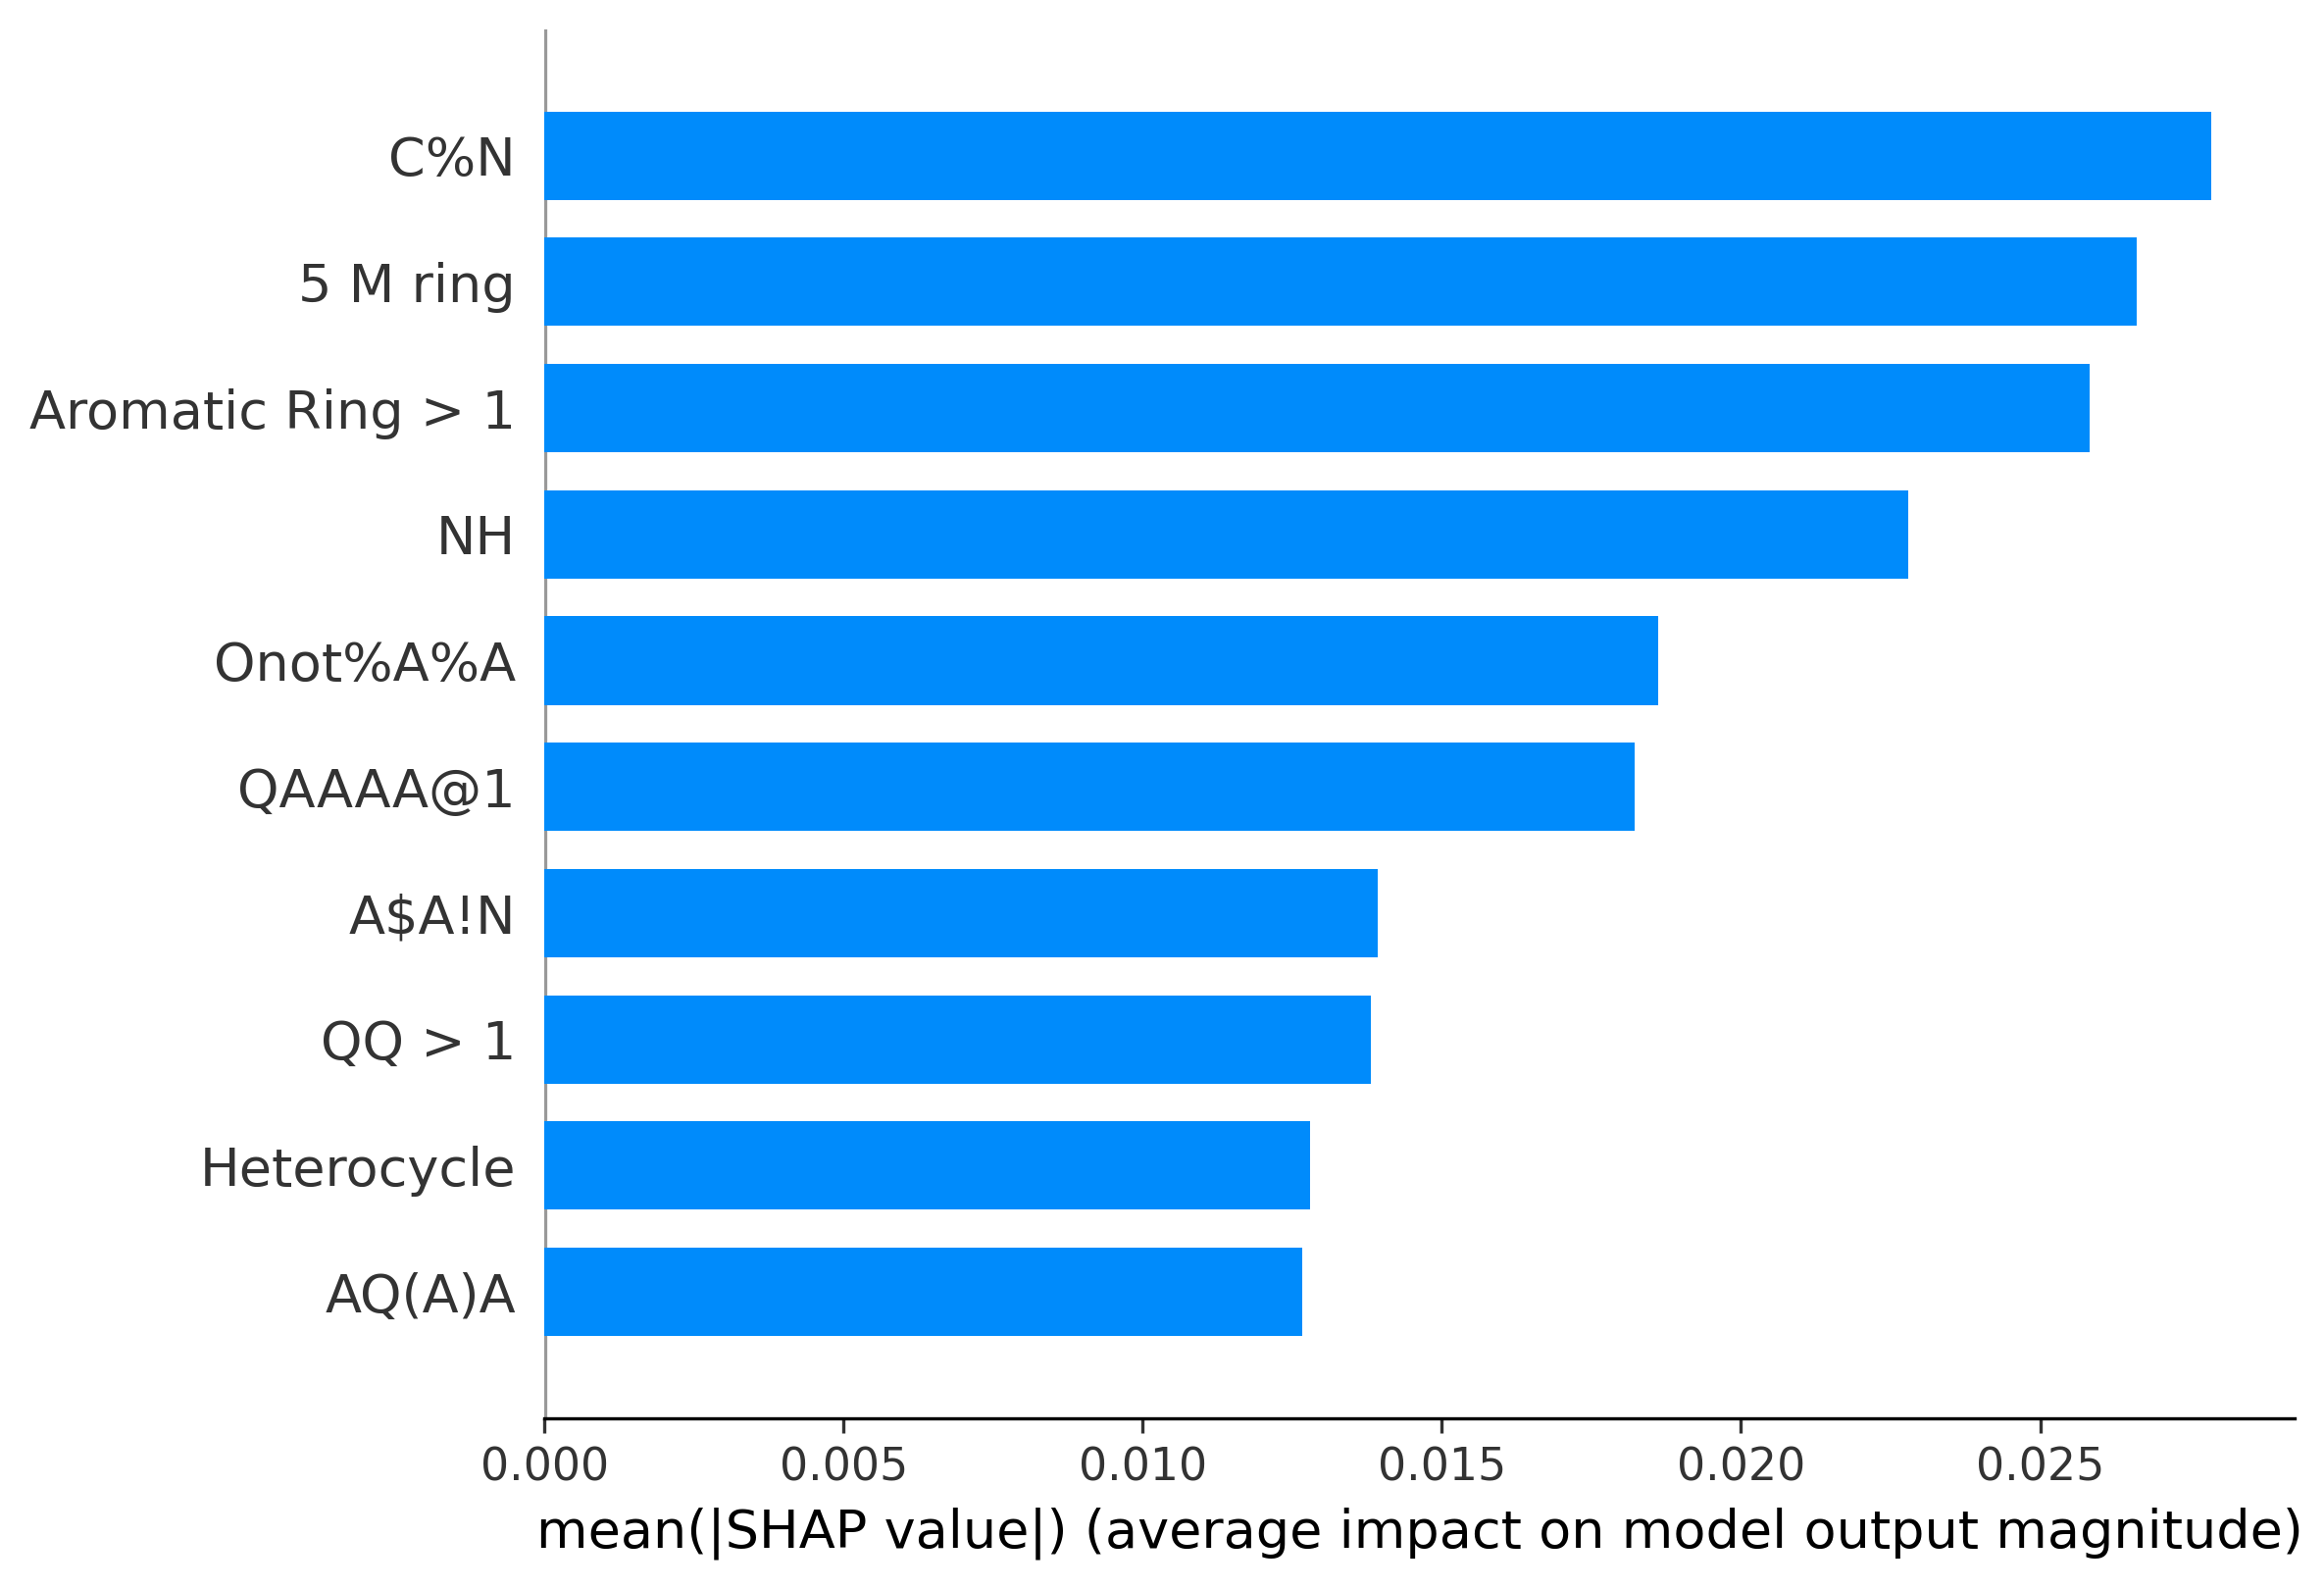

In [25]:
shap.summary_plot(shap_values[1], test_dataset.X, plot_type="bar", max_display=10,feature_names = result,show=False)

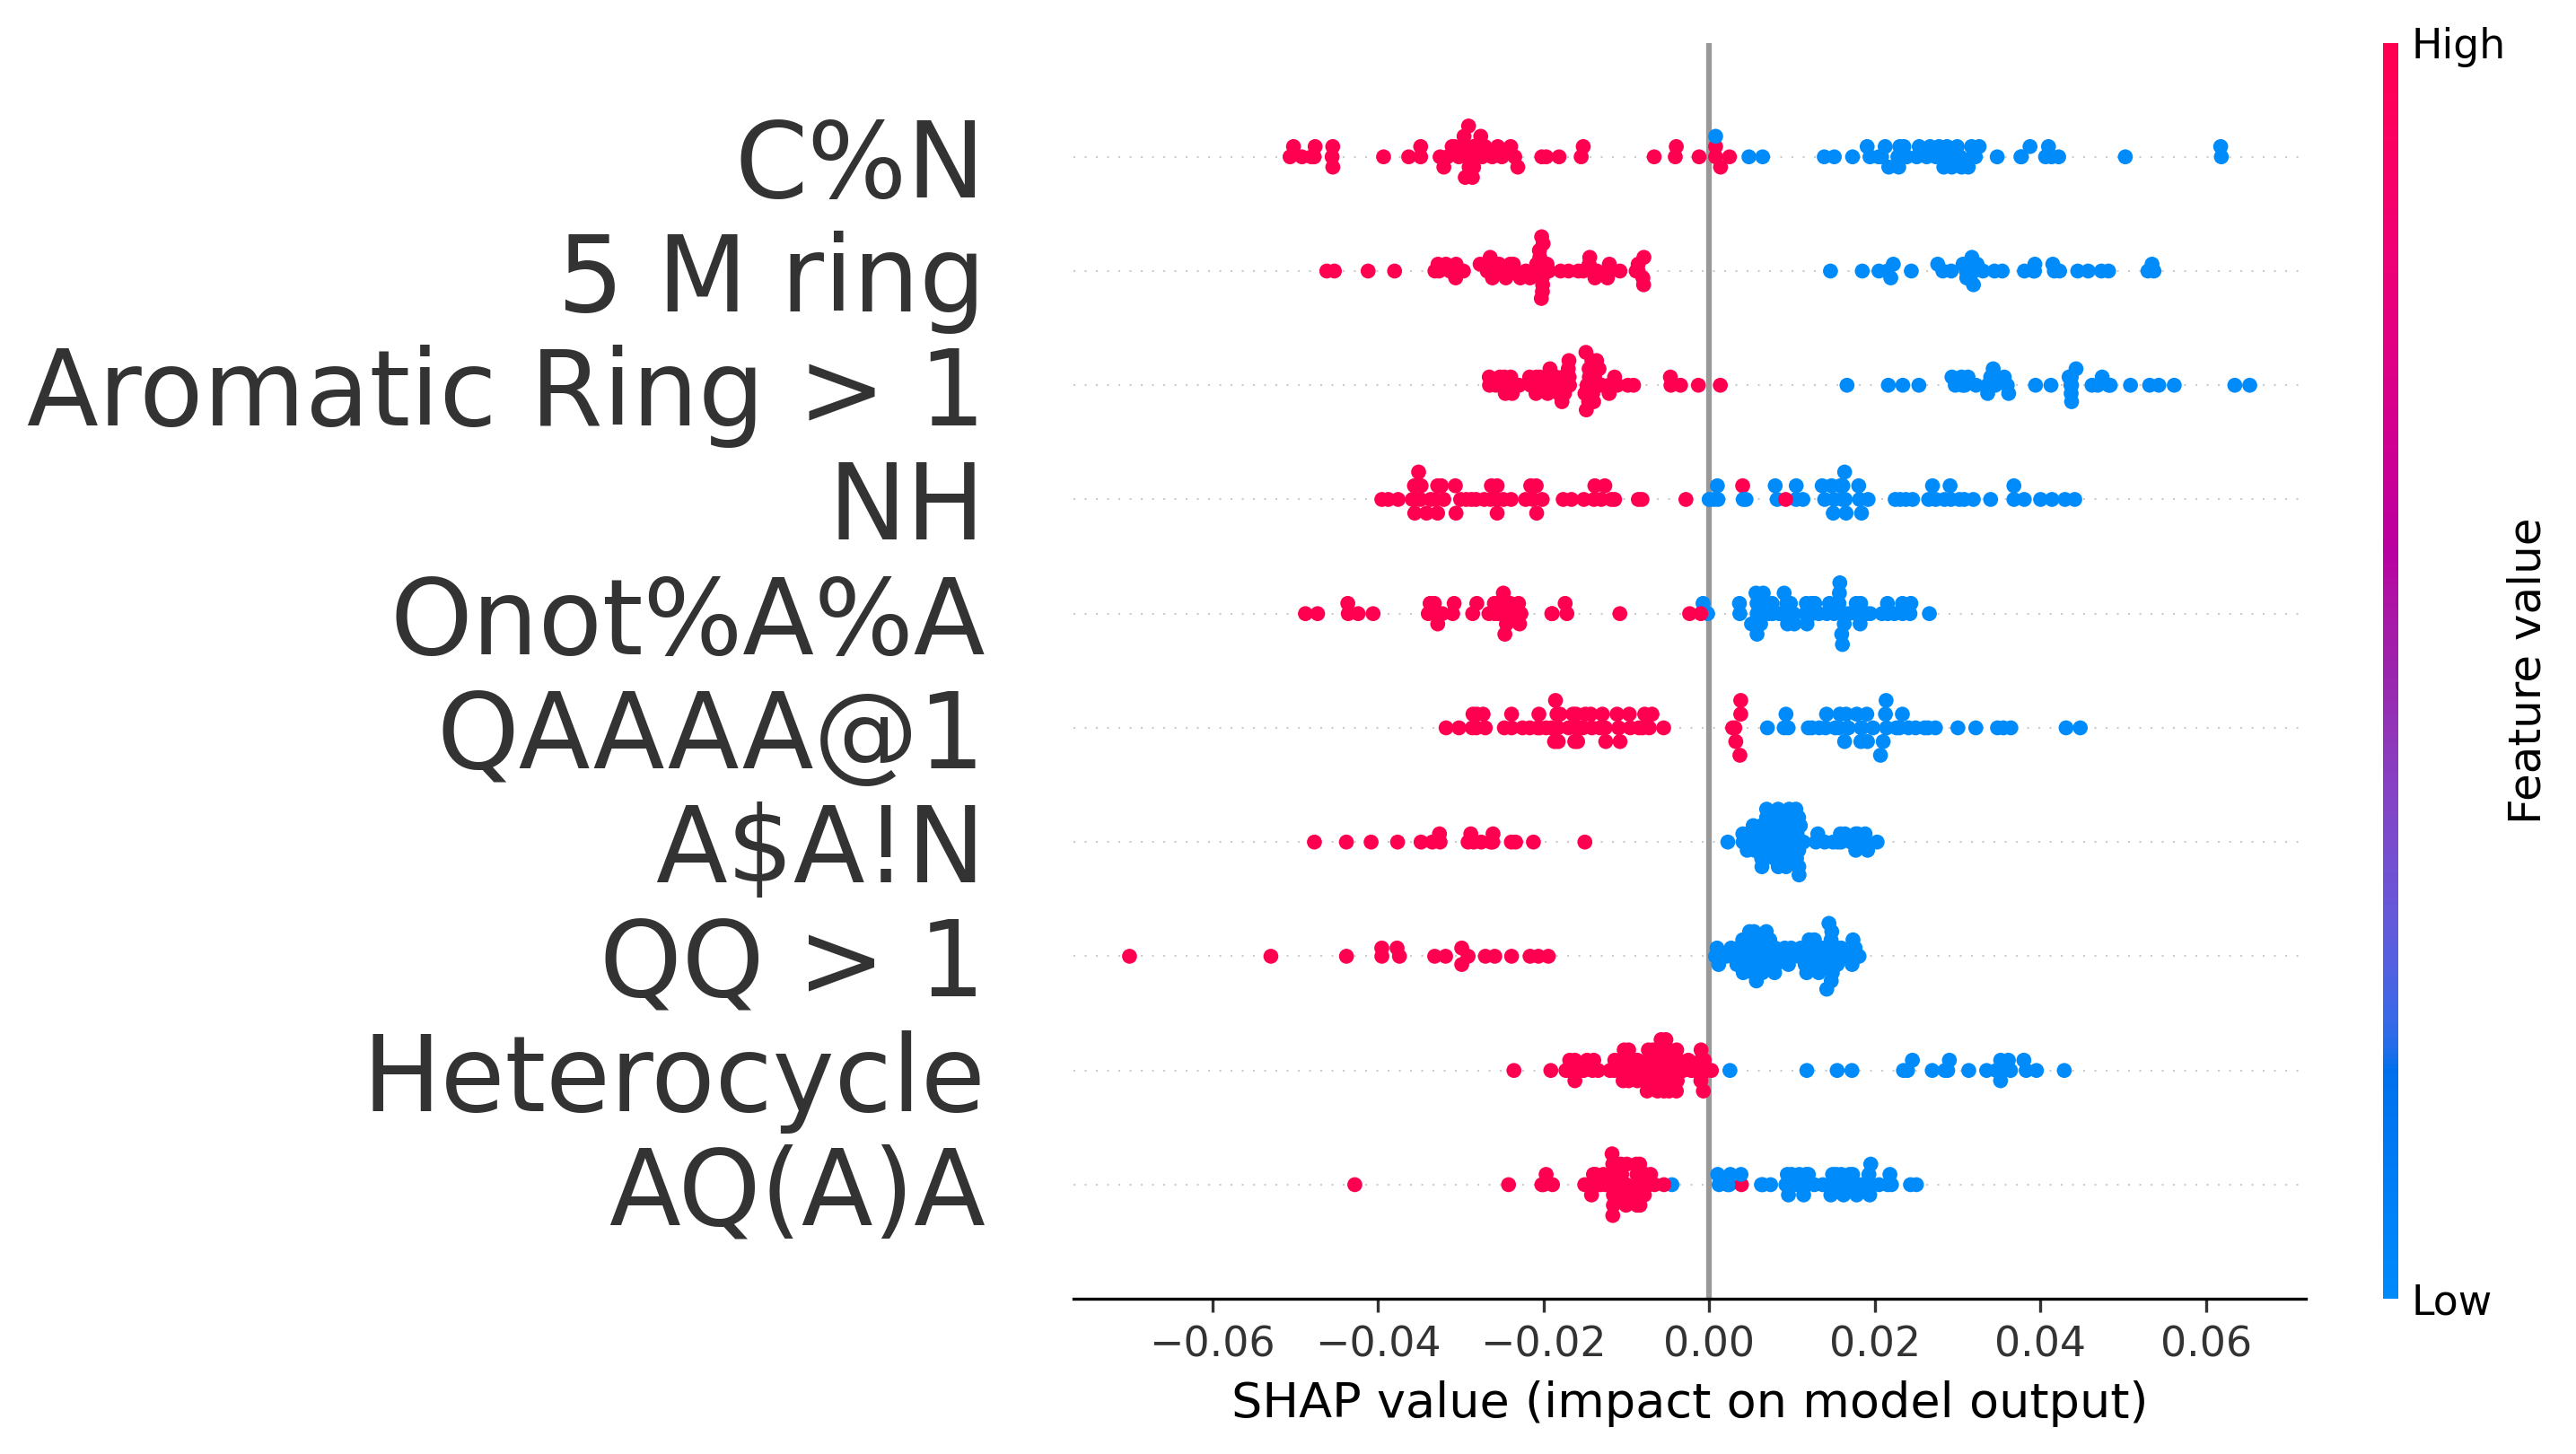

In [26]:
shap.summary_plot(shap_values[1], test_dataset.X,max_display=10,feature_names = result)

In [16]:
expected_value = explainer.expected_value

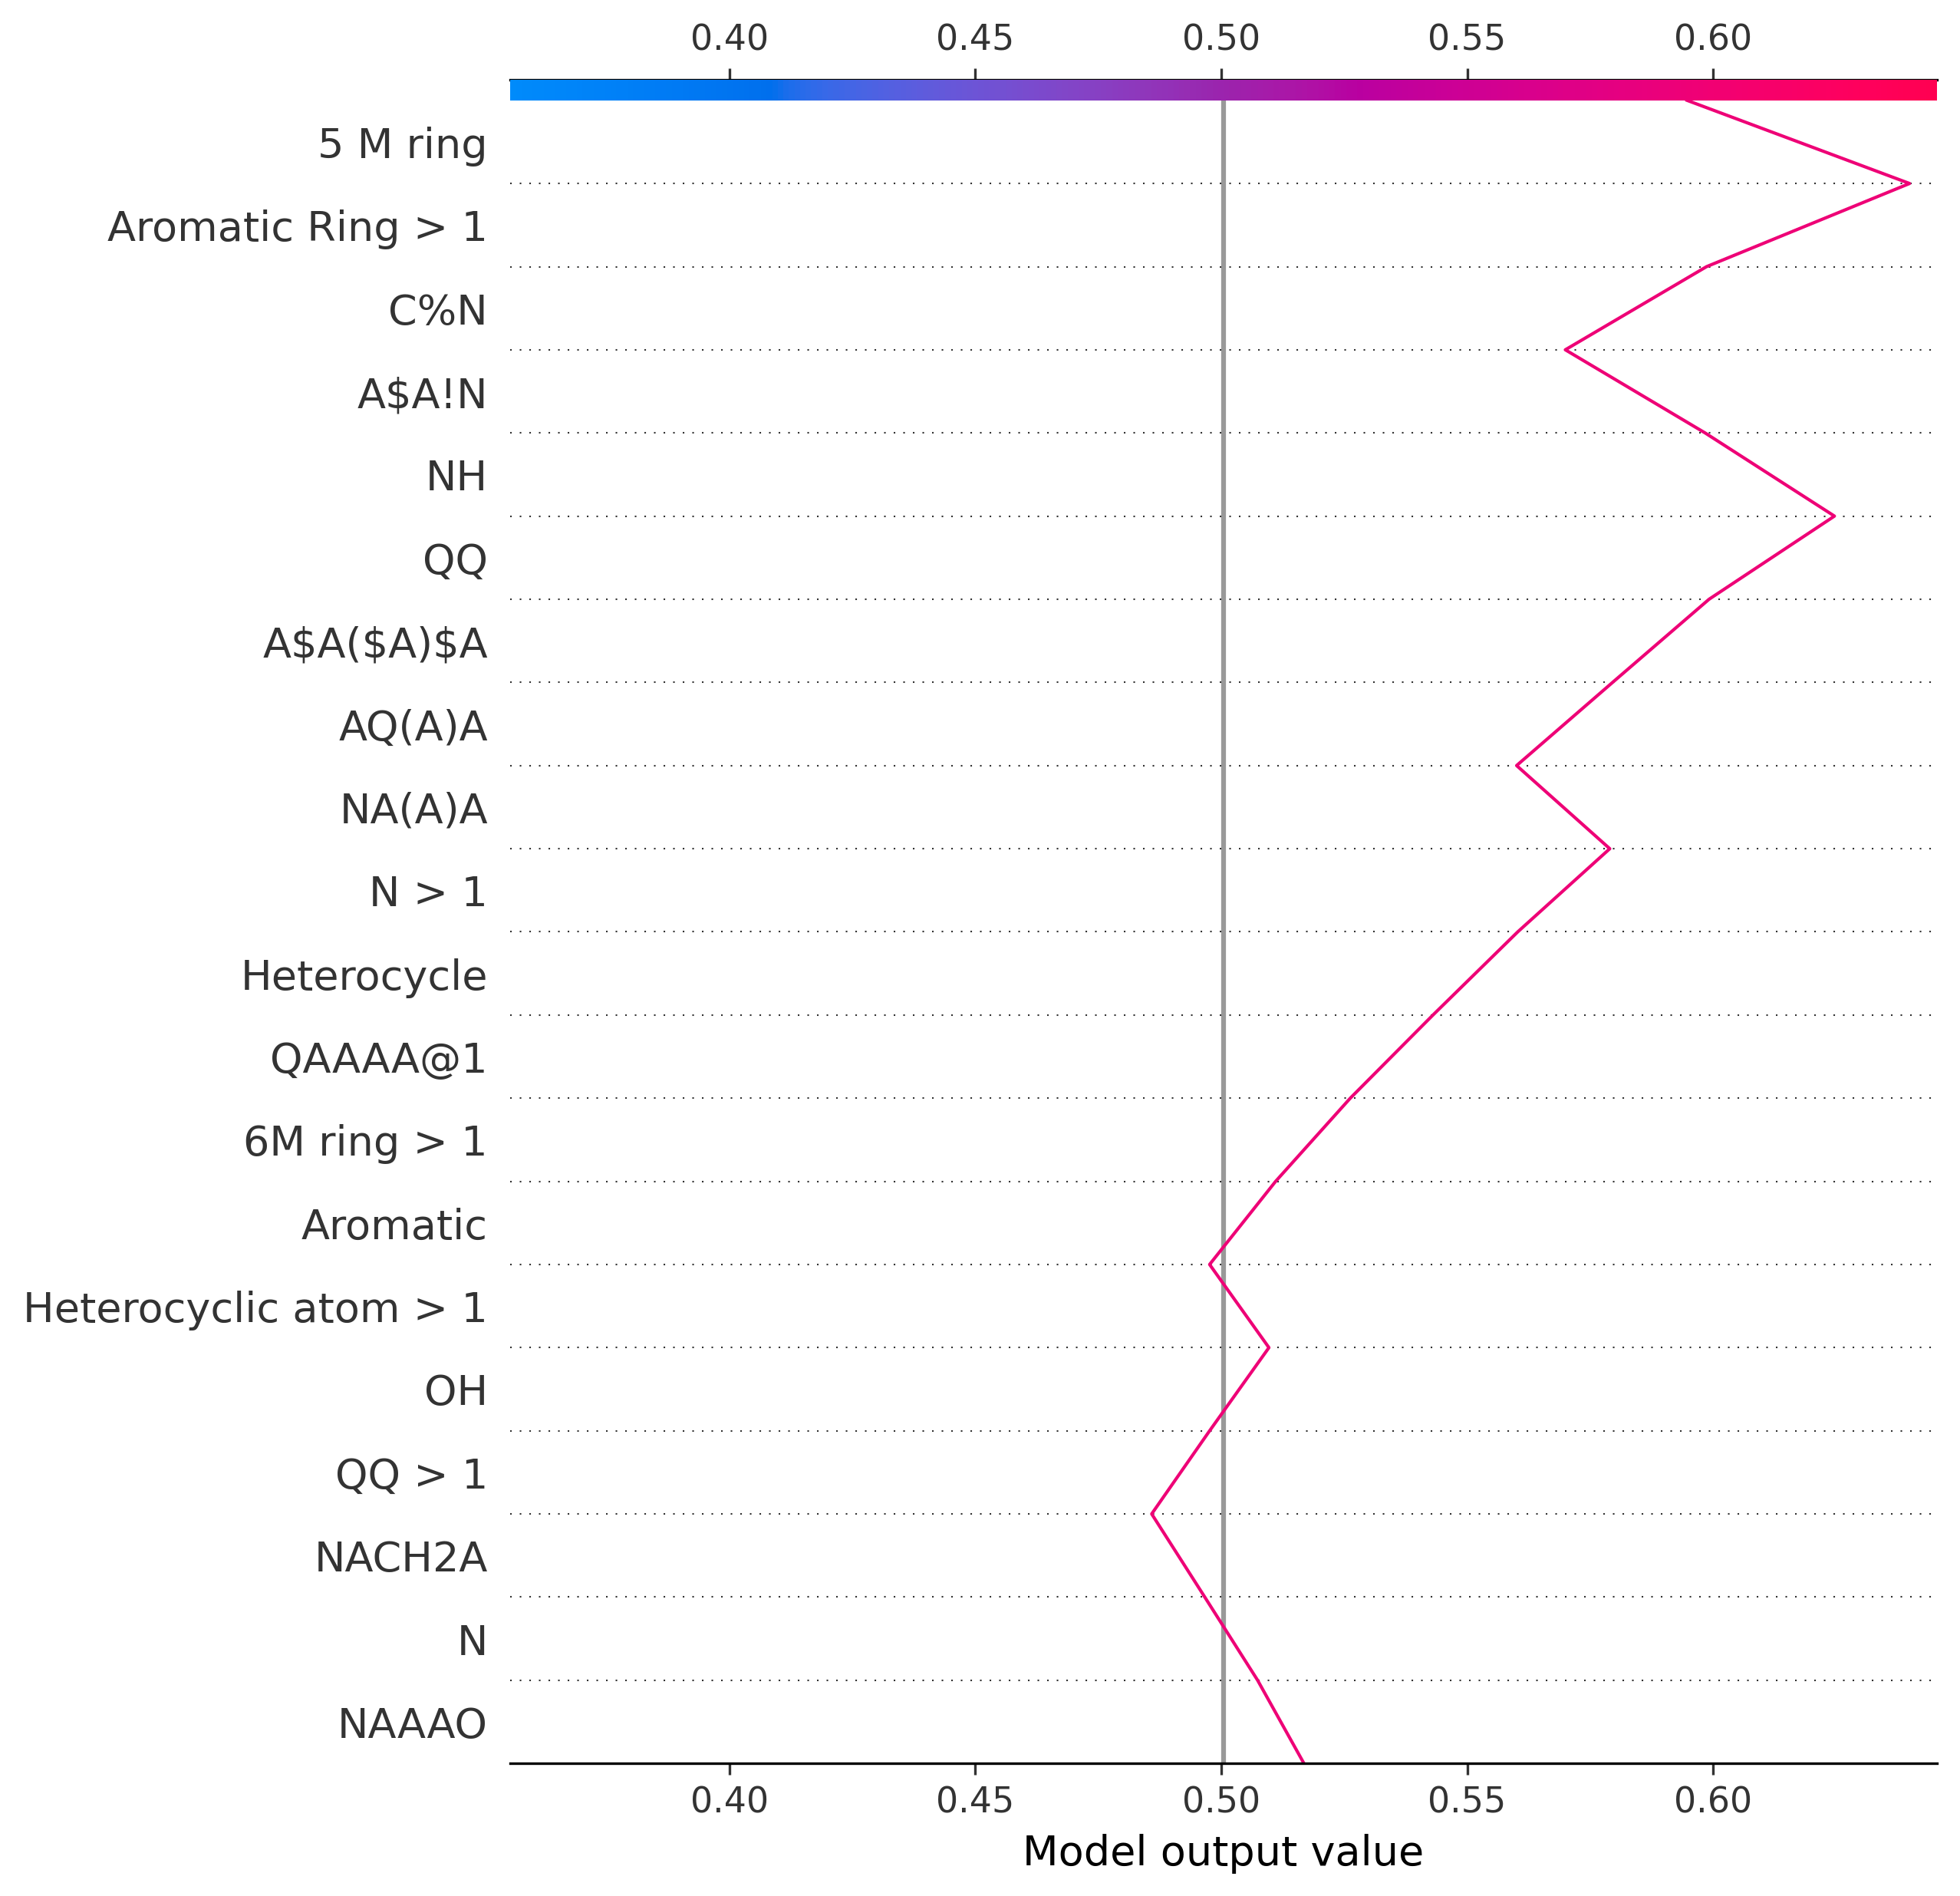

In [17]:
sample_idx = 0
shap.decision_plot(explainer.expected_value[1],  
                   shap_values[1][sample_idx],   
                   feature_names=result,         
                   )

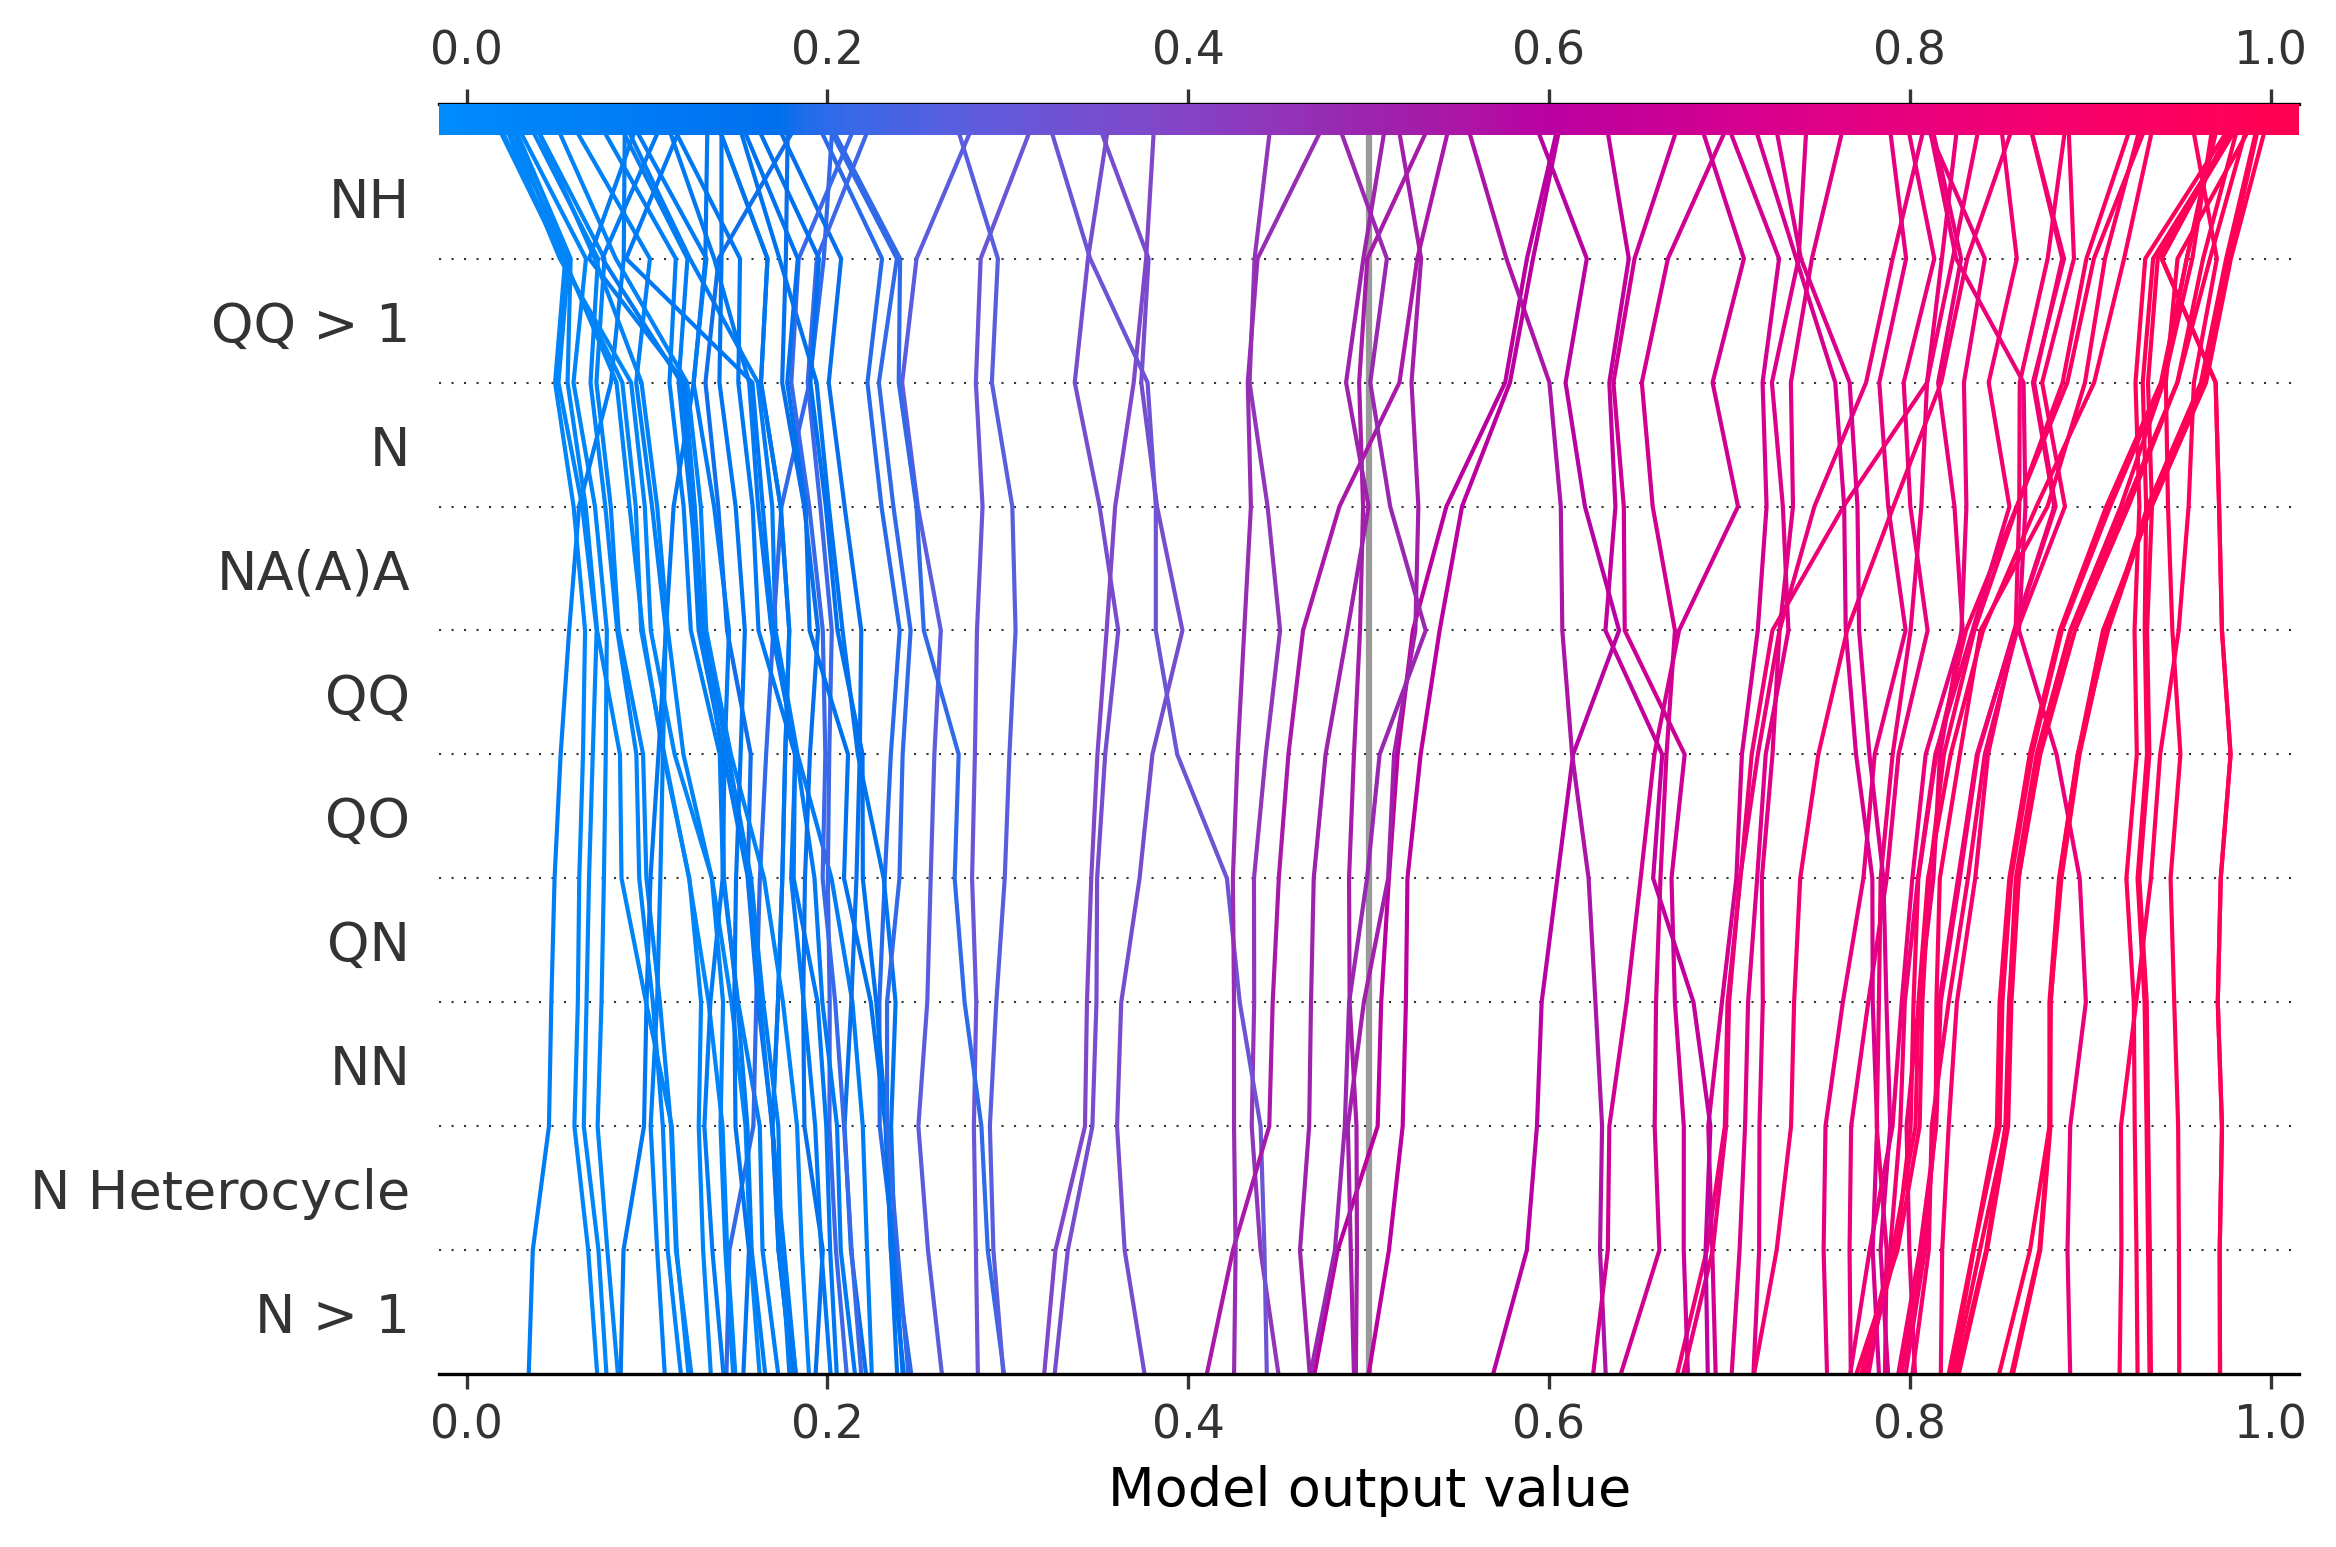

In [31]:
shap.decision_plot(expected_value[1], shap_values[1], test_dataset.X, feature_names = result,feature_order='hclust',feature_display_range=slice(None,-11,-1))

# global_force_plot

In [18]:
shap.force_plot(explainer.expected_value[1], shap_values[1],test_dataset.X,feature_names = result)

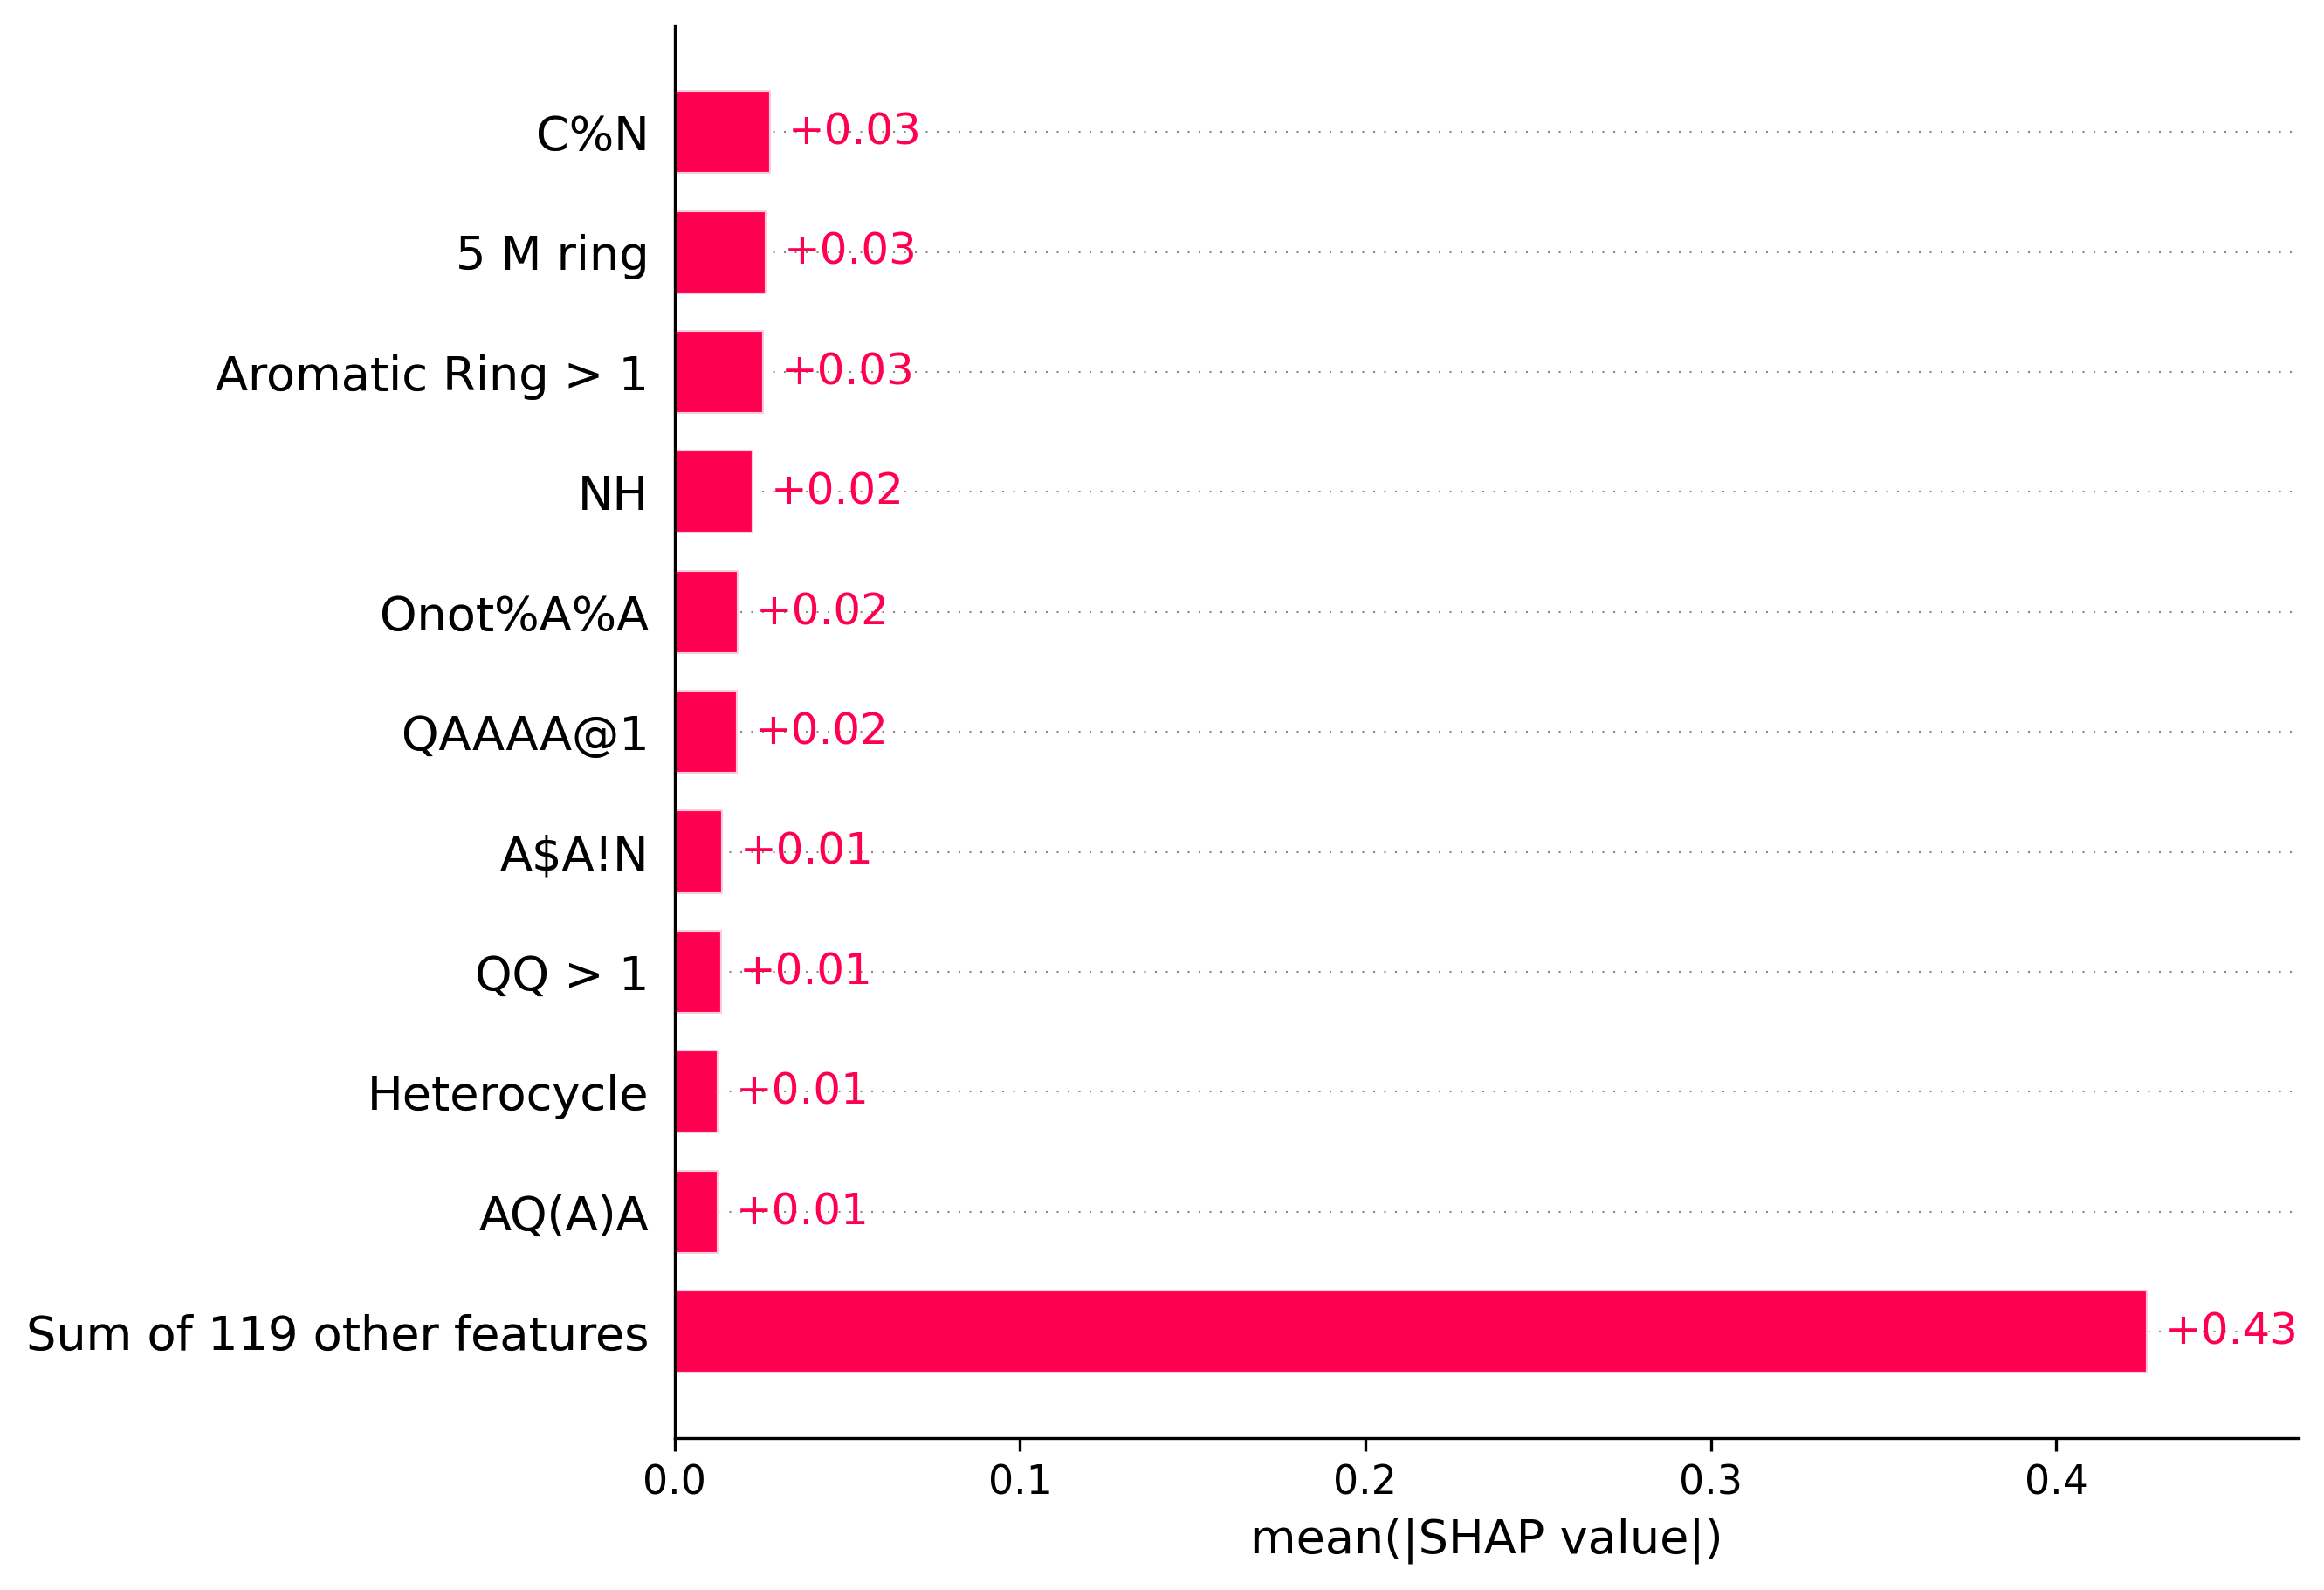

In [37]:
explainer2 = shap.Explainer(rf_model,feature_names = result)
shap_values2 = explainer2(test_dataset.X)
shap.plots.bar(shap_values2[:,:,0], max_display=11)

# plot_experimental_compounds

In [19]:
exp_compounds = pd.read_excel('../../data/experimental_compounds.xlsx')

In [20]:
exp_compounds_featrures = featurizer.featurize(exp_compounds['SMILES'])

In [21]:
mask = vt.get_support(indices=True)
exp_compounds_selected = exp_compounds_featrures[:, mask]

In [22]:
exp_compounds_prob = rf_model.predict_proba(exp_compounds_selected)

In [23]:
exp_compounds_prob

array([[0.04308713, 0.95691287],
       [0.07770397, 0.92229603],
       [0.11006722, 0.88993278],
       [0.04654792, 0.95345208],
       [0.00770054, 0.99229946]])

In [24]:
shap_values_3 = explainer.shap_values(exp_compounds_selected)

In [45]:
shap.force_plot(explainer.expected_value[1], shap_values_3[1],exp_compounds_featrures,feature_names = result)

# Carvacrol


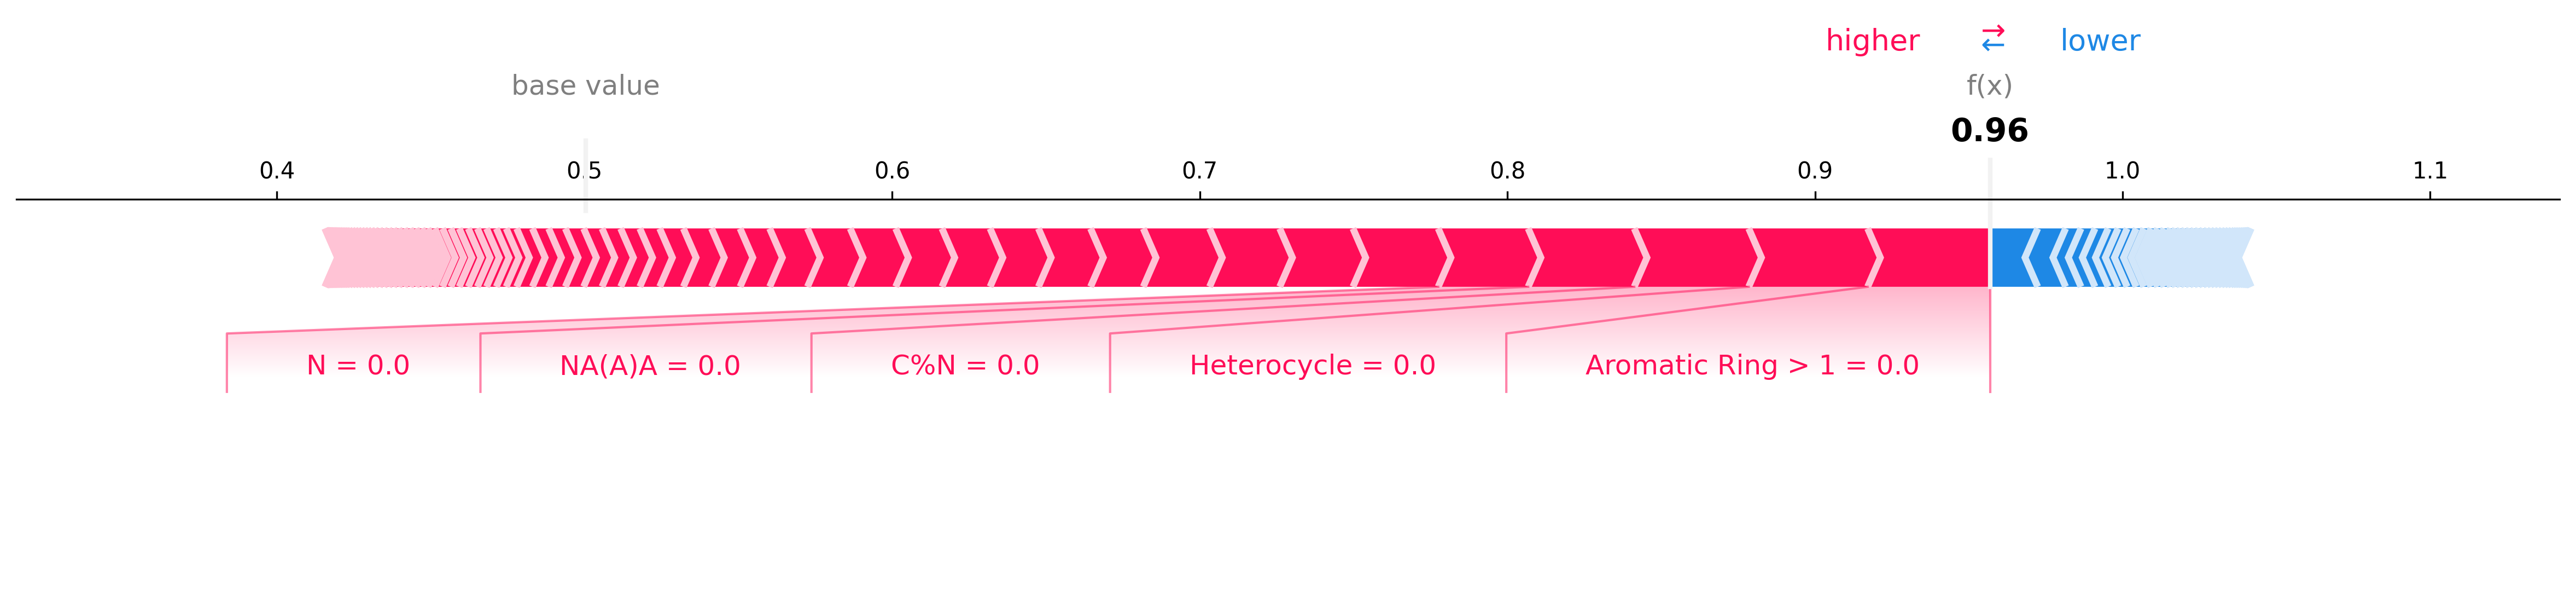

In [32]:
#fig = plt.figure()
sample = 0 
shap.force_plot(explainer.expected_value[1],
                shap_values_3[1][sample,:],
                exp_compounds_selected[sample,:],
                feature_names=result,
                matplotlib=True,
              show = False
               )
#plt.savefig("./shap/force_plot.png") 
plt.show()
plt.clf()

<Figure size 1920x1440 with 0 Axes>

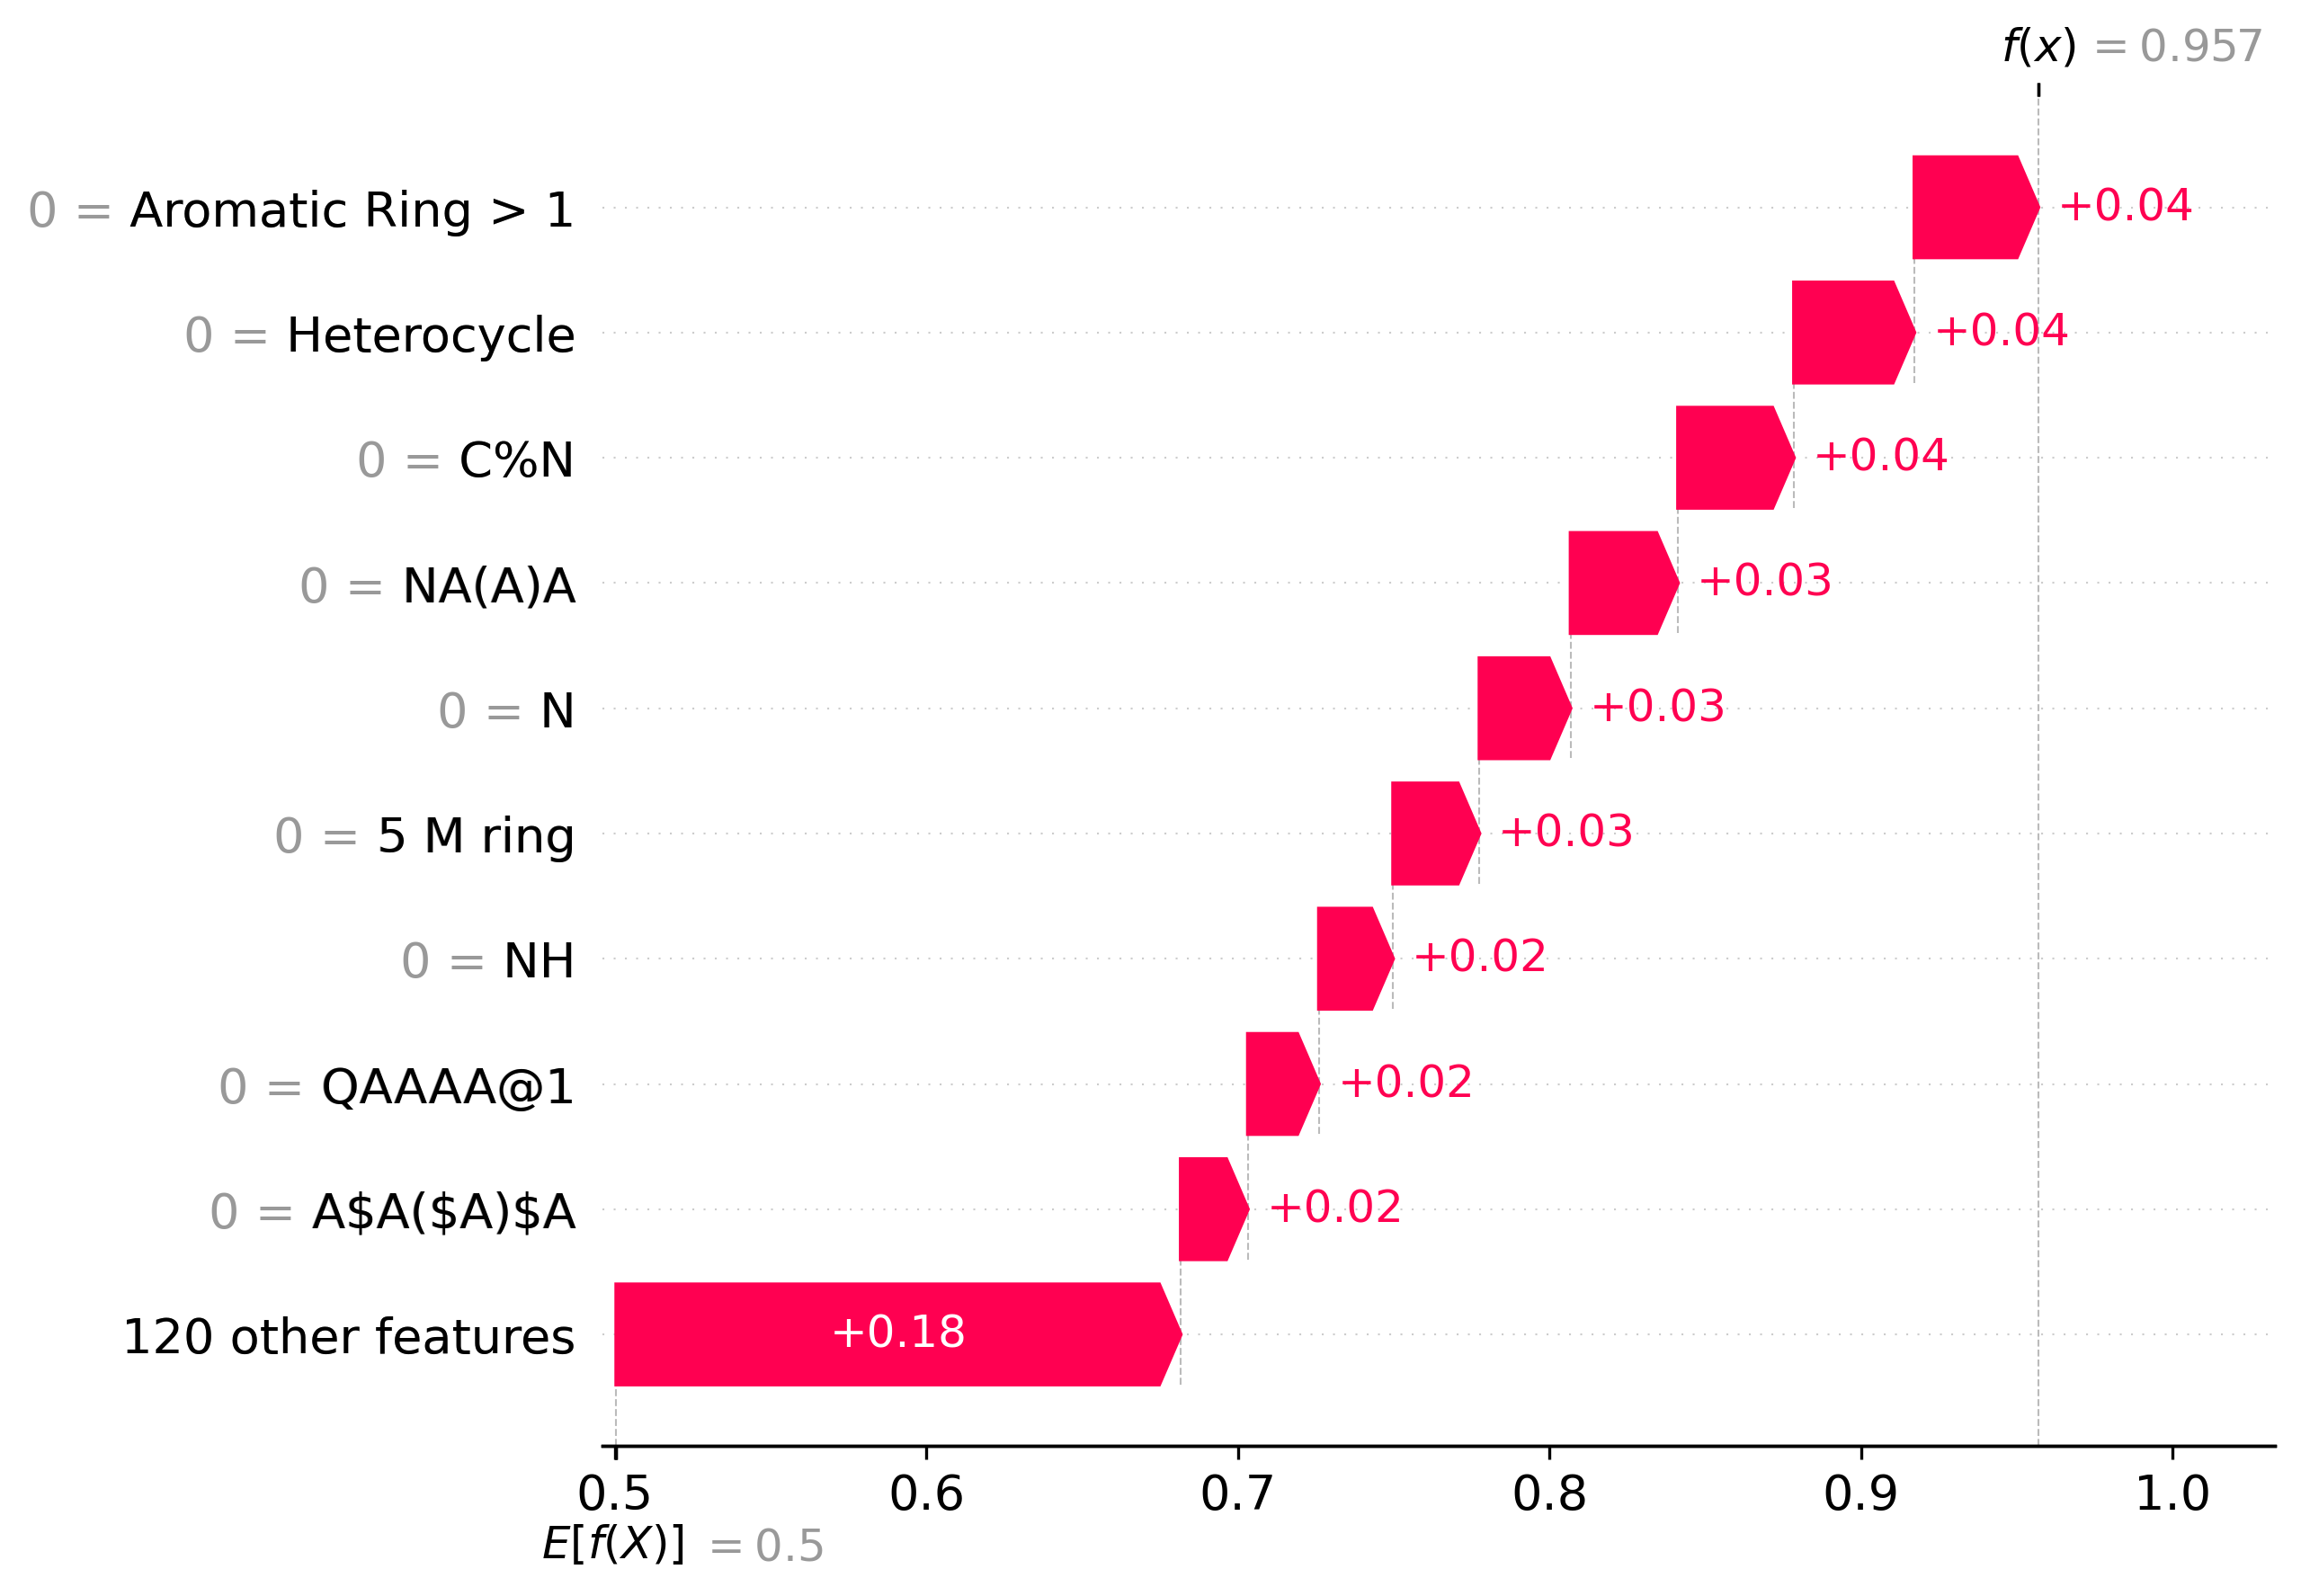

In [33]:
sample_idx = 0 
shap_value_sample = shap_values_3[1][sample_idx]

fig = plt.figure()
shap.plots.waterfall(shap.Explanation(values=shap_value_sample, 
                                      base_values=explainer.expected_value[1], 
                                      data=exp_compounds_selected[sample_idx], 
                                      feature_names=result),
                                        #max_display=129,
                                      show=False)

plt.yticks(fontsize=28)
#plt.savefig("./shap/waterfall.png",dpi=600) 
plt.show()
# plt.clf()

# Safranal


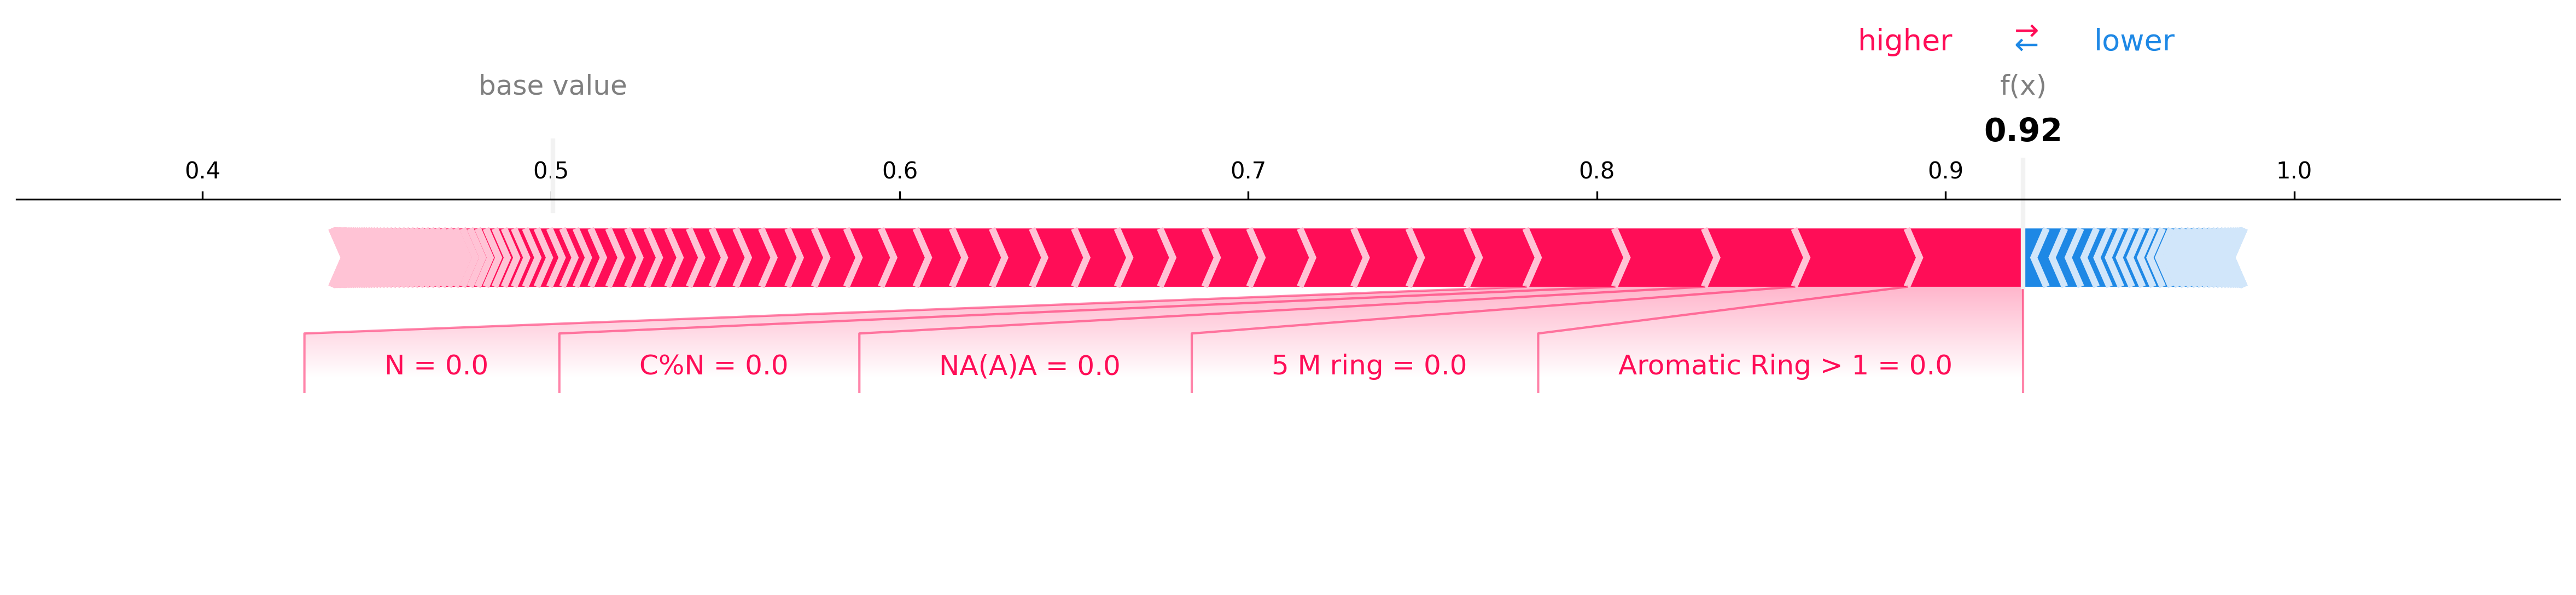

In [51]:
#fig = plt.figure()
sample = 1 
shap.force_plot(explainer.expected_value[1], 
                shap_values_3[1][sample,:],
                exp_compounds_selected[sample],
                feature_names=result,
                matplotlib=True,
               show = False)
#plt.savefig("./shap/force_plot.png") 
plt.show()
plt.clf()

<Figure size 1920x1440 with 0 Axes>

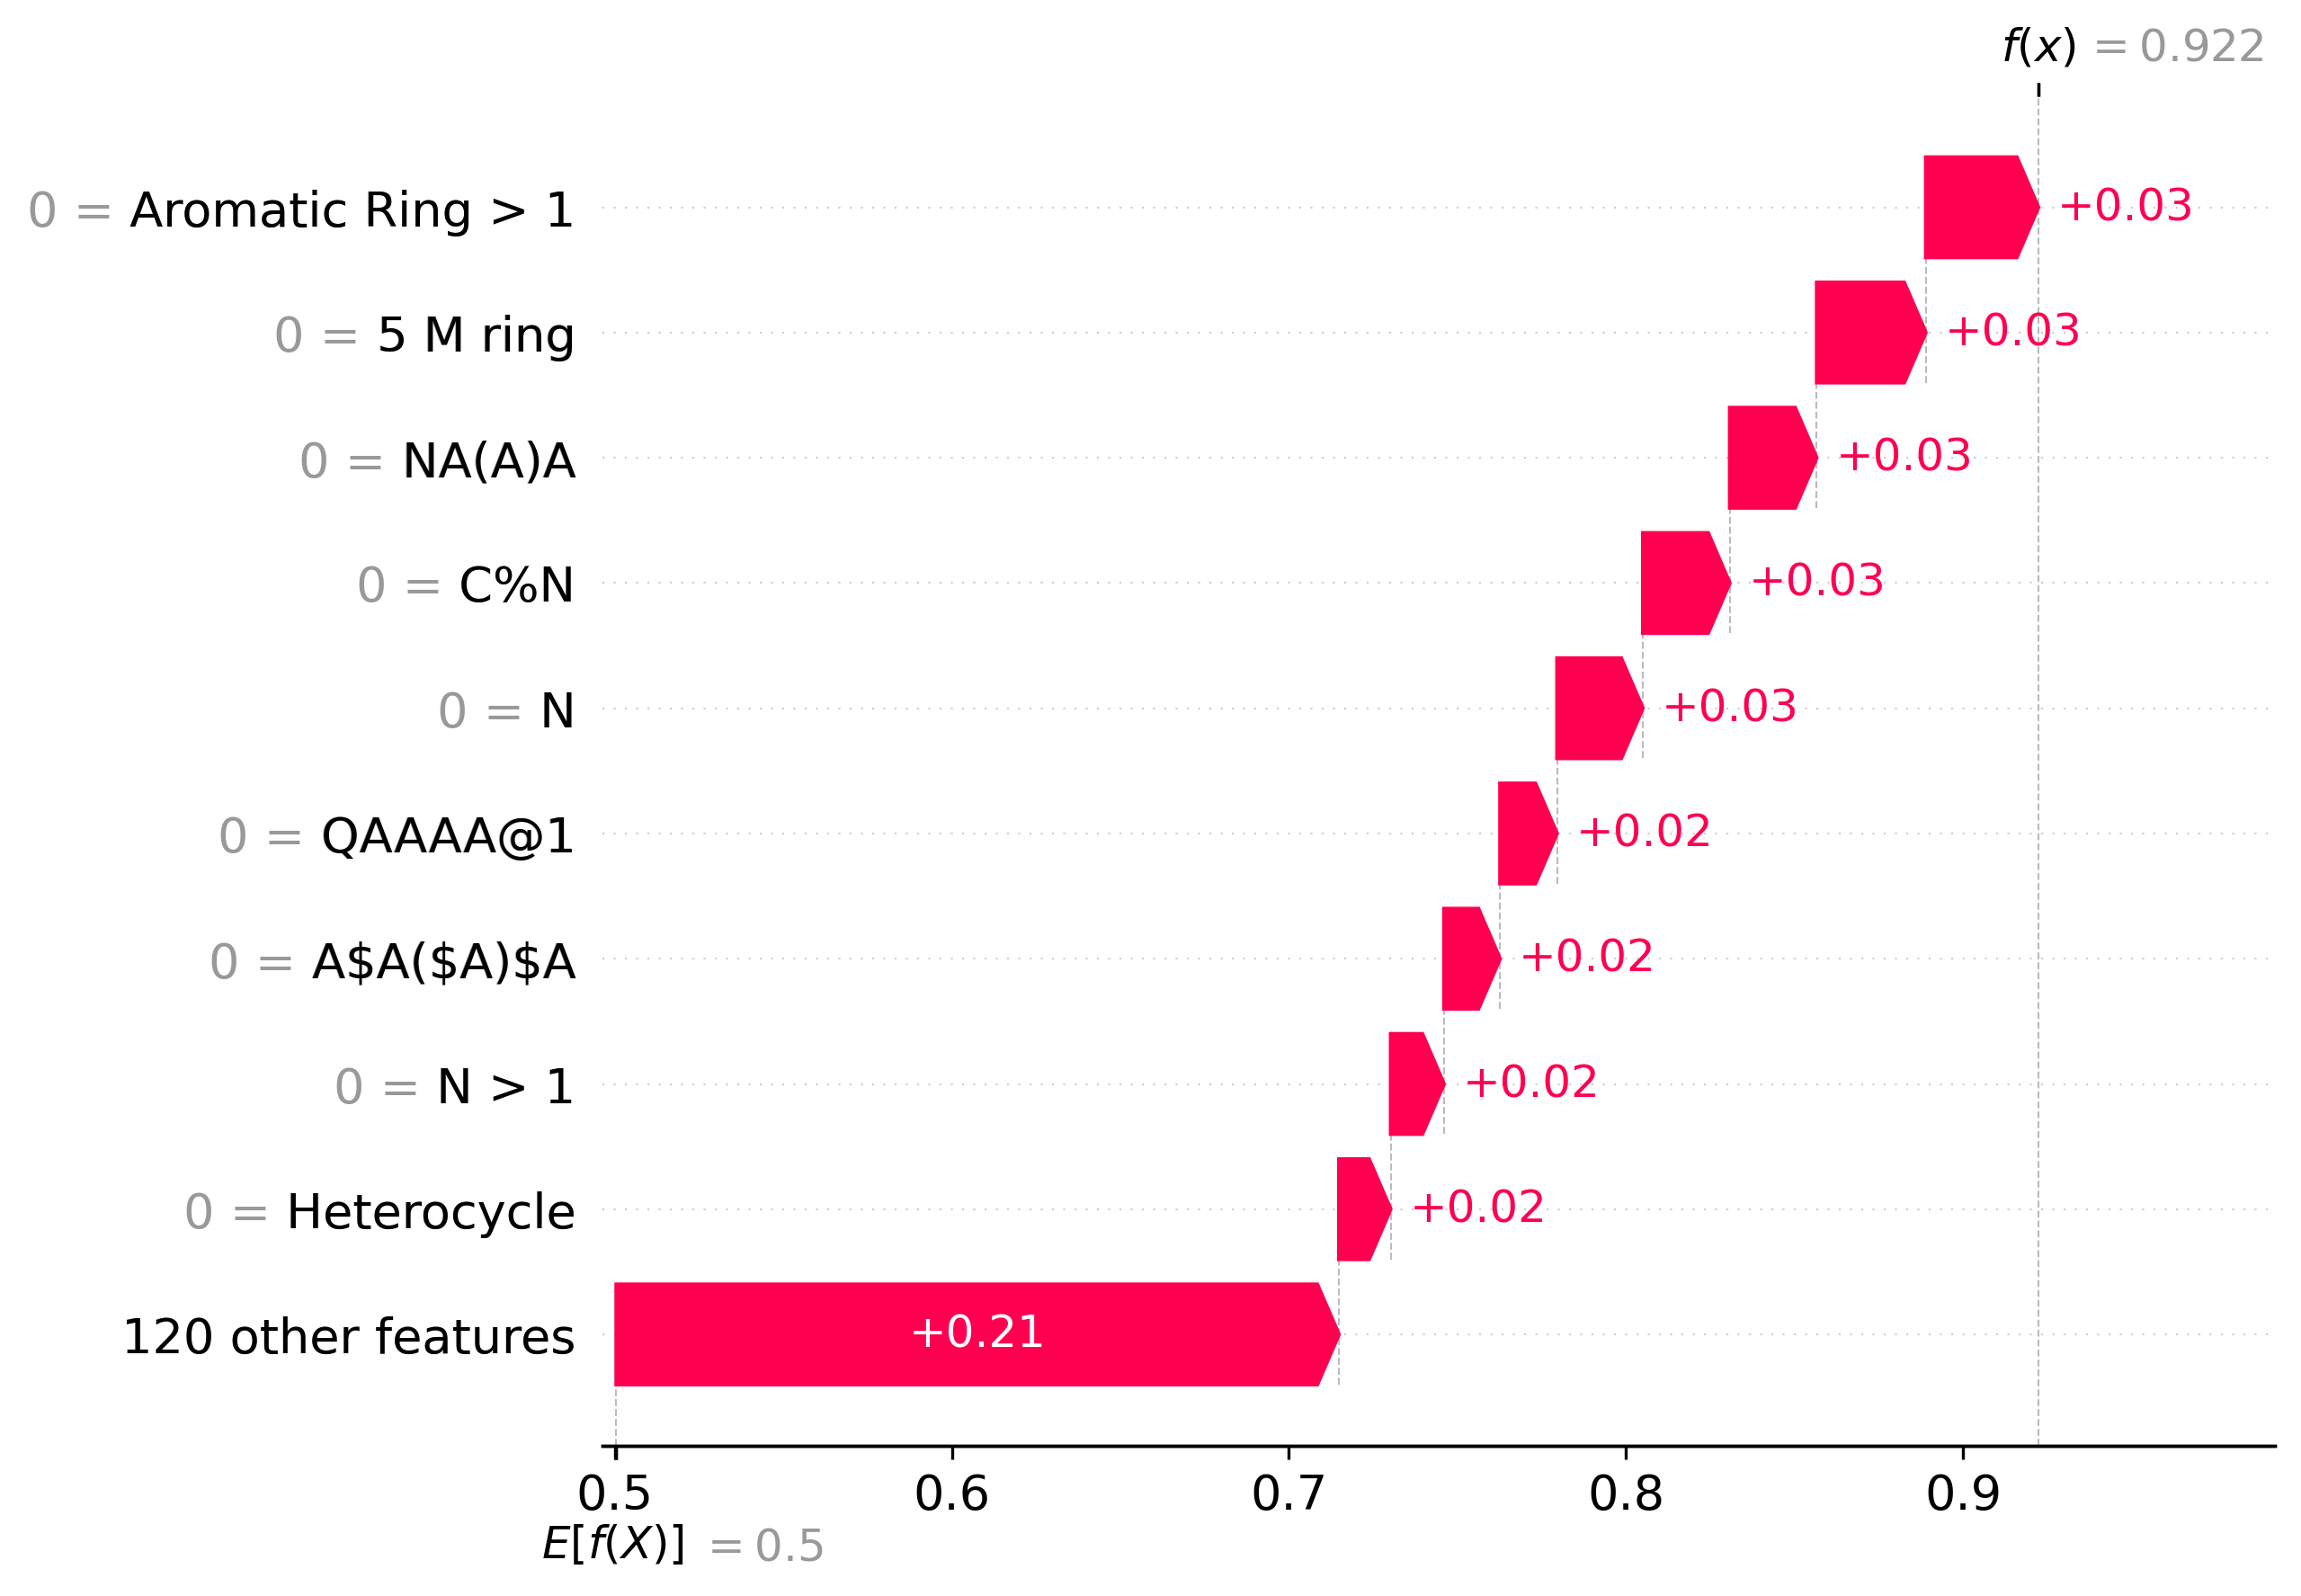

In [29]:
sample_idx = 1
shap_value_sample = shap_values_3[1][sample_idx]

fig = plt.figure()
shap.plots.waterfall(shap.Explanation(values=shap_value_sample, 
                                      base_values=explainer.expected_value[1], 
                                      data=exp_compounds_selected[sample_idx], 
                                      feature_names=result),
                     #max_display=20,
                                      show=False)

plt.yticks(fontsize=28)
#plt.savefig("./shap/waterfall.png",dpi=600) 
plt.show()
# plt.clf()

# Vanillin


<Figure size 1920x1440 with 0 Axes>

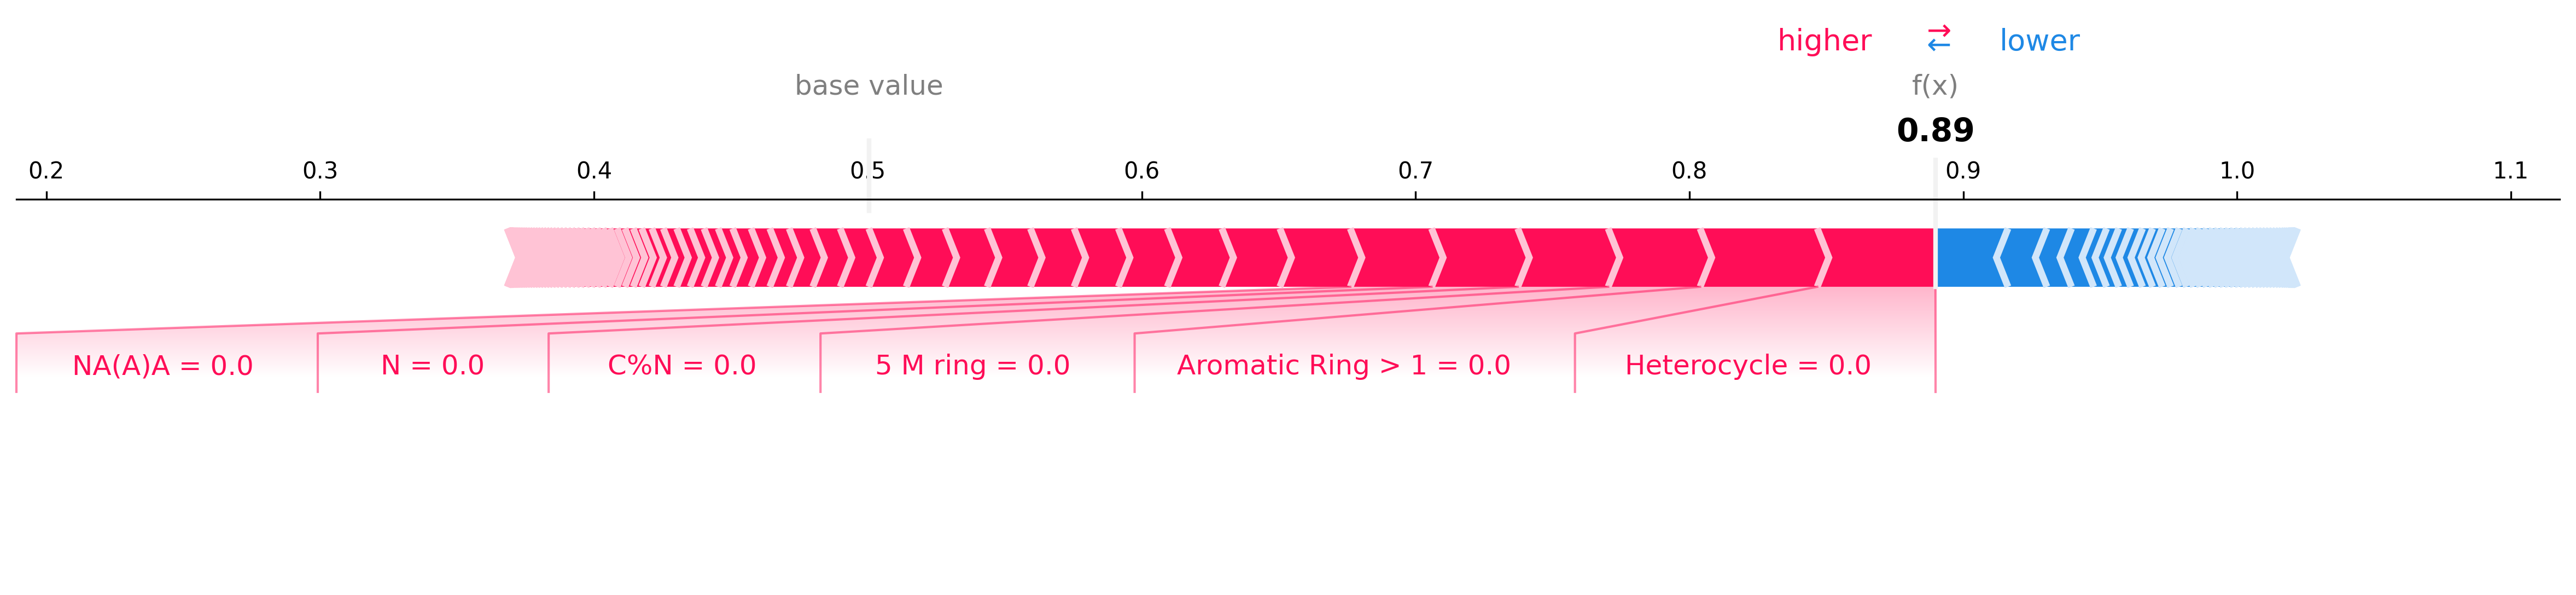

In [64]:
#fig = plt.figure()
sample = 2
shap.force_plot(explainer.expected_value[1],
                shap_values_3[1][sample,:],
                exp_compounds_selected[sample],
                feature_names=result,
                matplotlib=True,
               show = False)
#plt.savefig("./shap/force_plot.png") 
plt.show()
plt.clf()

<Figure size 1920x1440 with 0 Axes>

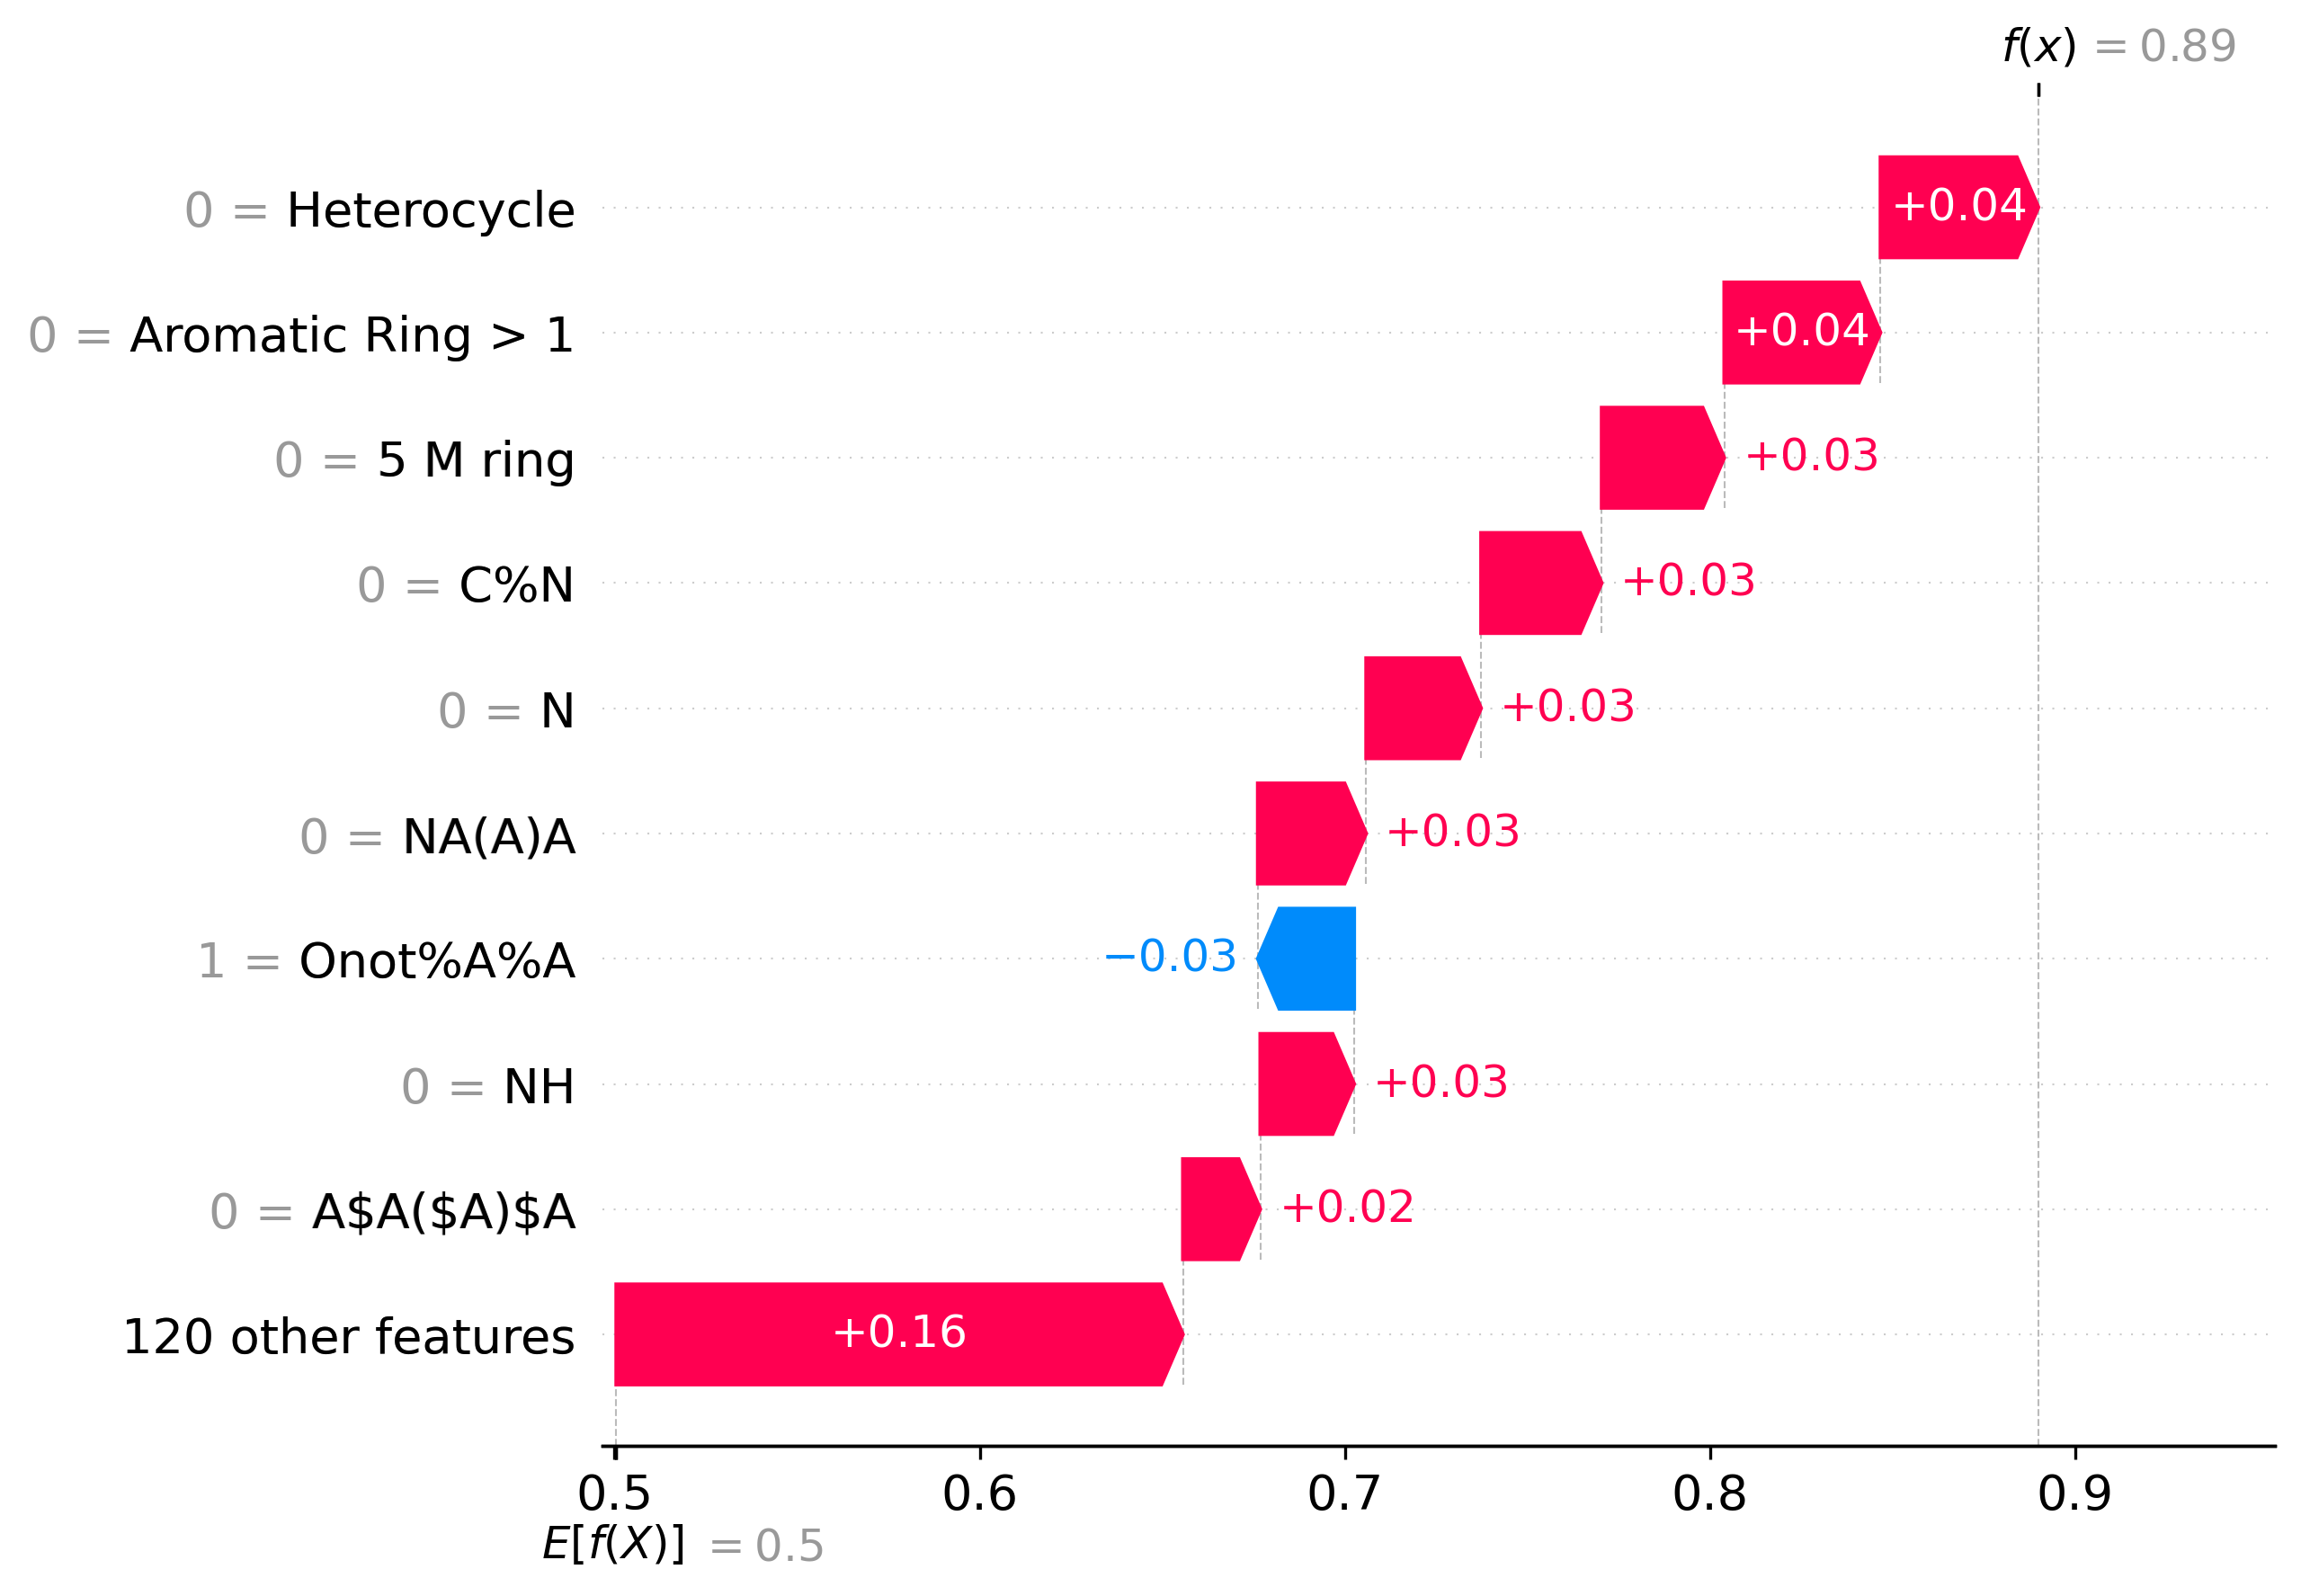

In [55]:
sample_idx = 2
shap_value_sample = shap_values_3[1][sample_idx]

fig = plt.figure()
shap.plots.waterfall(shap.Explanation(values=shap_value_sample, 
                                      base_values=explainer.expected_value[1], 
                                      data=exp_compounds_selected[sample_idx], 
                                      feature_names=result),
                                      show=False)

plt.yticks(fontsize=28)
#plt.savefig("./shap/waterfall.png",dpi=600) 
plt.show()
# plt.clf()

# Methyleugenol

<Figure size 1920x1440 with 0 Axes>

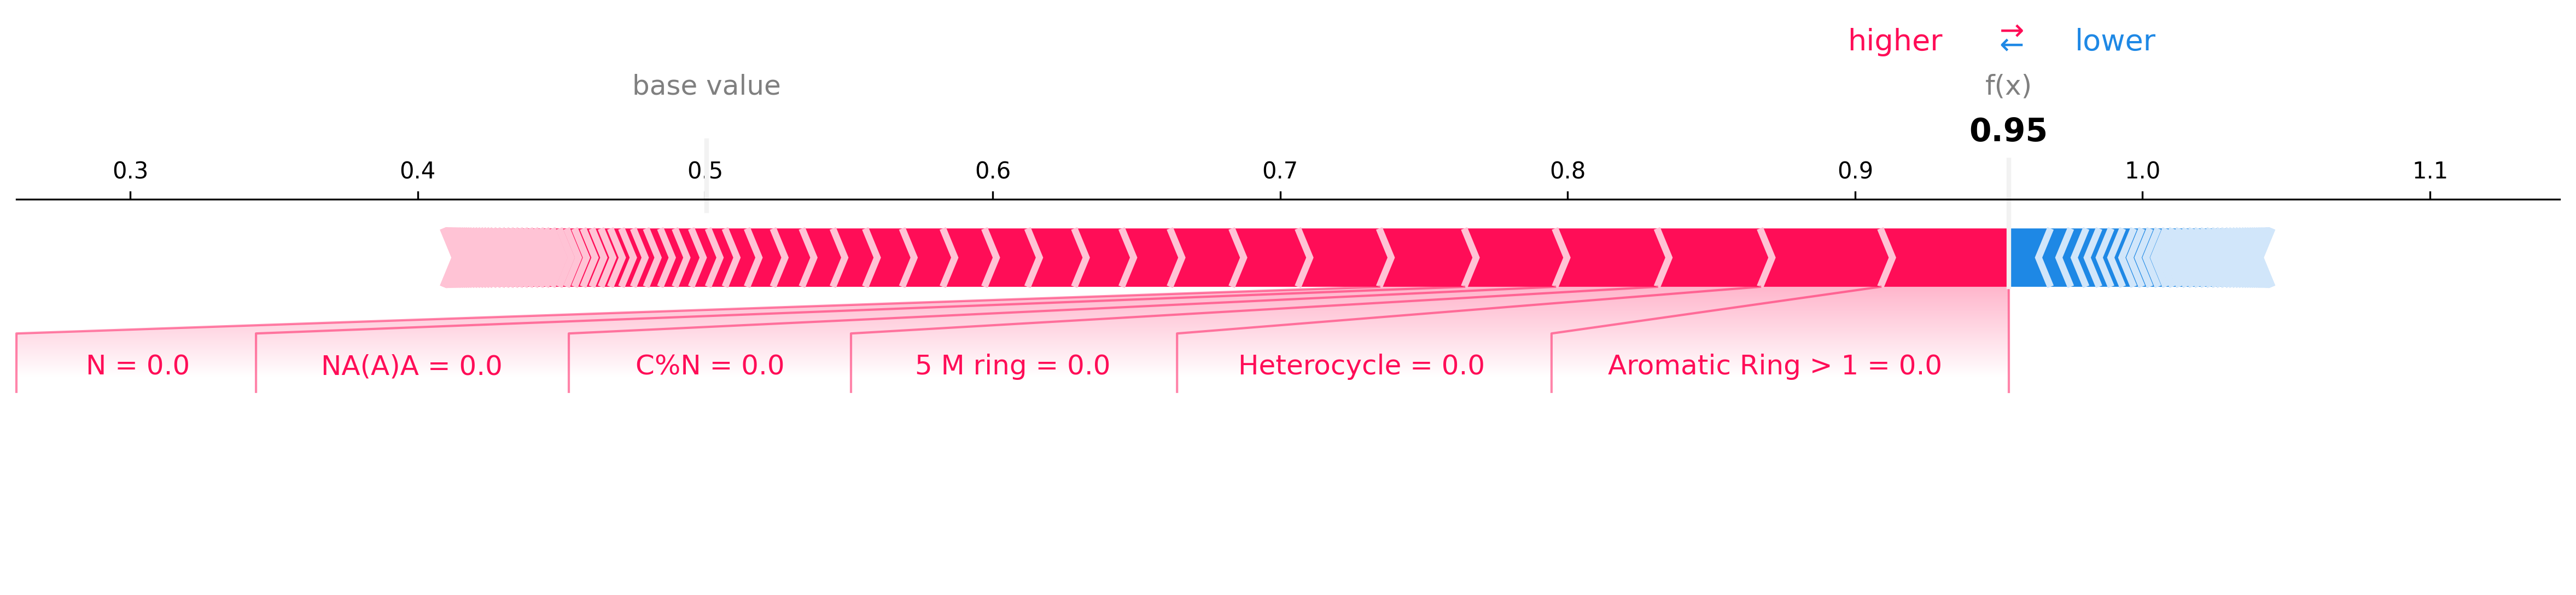

In [65]:
#fig = plt.figure()
sample = 3
shap.force_plot(explainer.expected_value[1],
                shap_values_3[1][sample,:],
                exp_compounds_selected[sample],
                feature_names=result,
                matplotlib=True,
               show = False)
#plt.savefig("./shap/force_plot.png") 
plt.show()
plt.clf()

<Figure size 1920x1440 with 0 Axes>

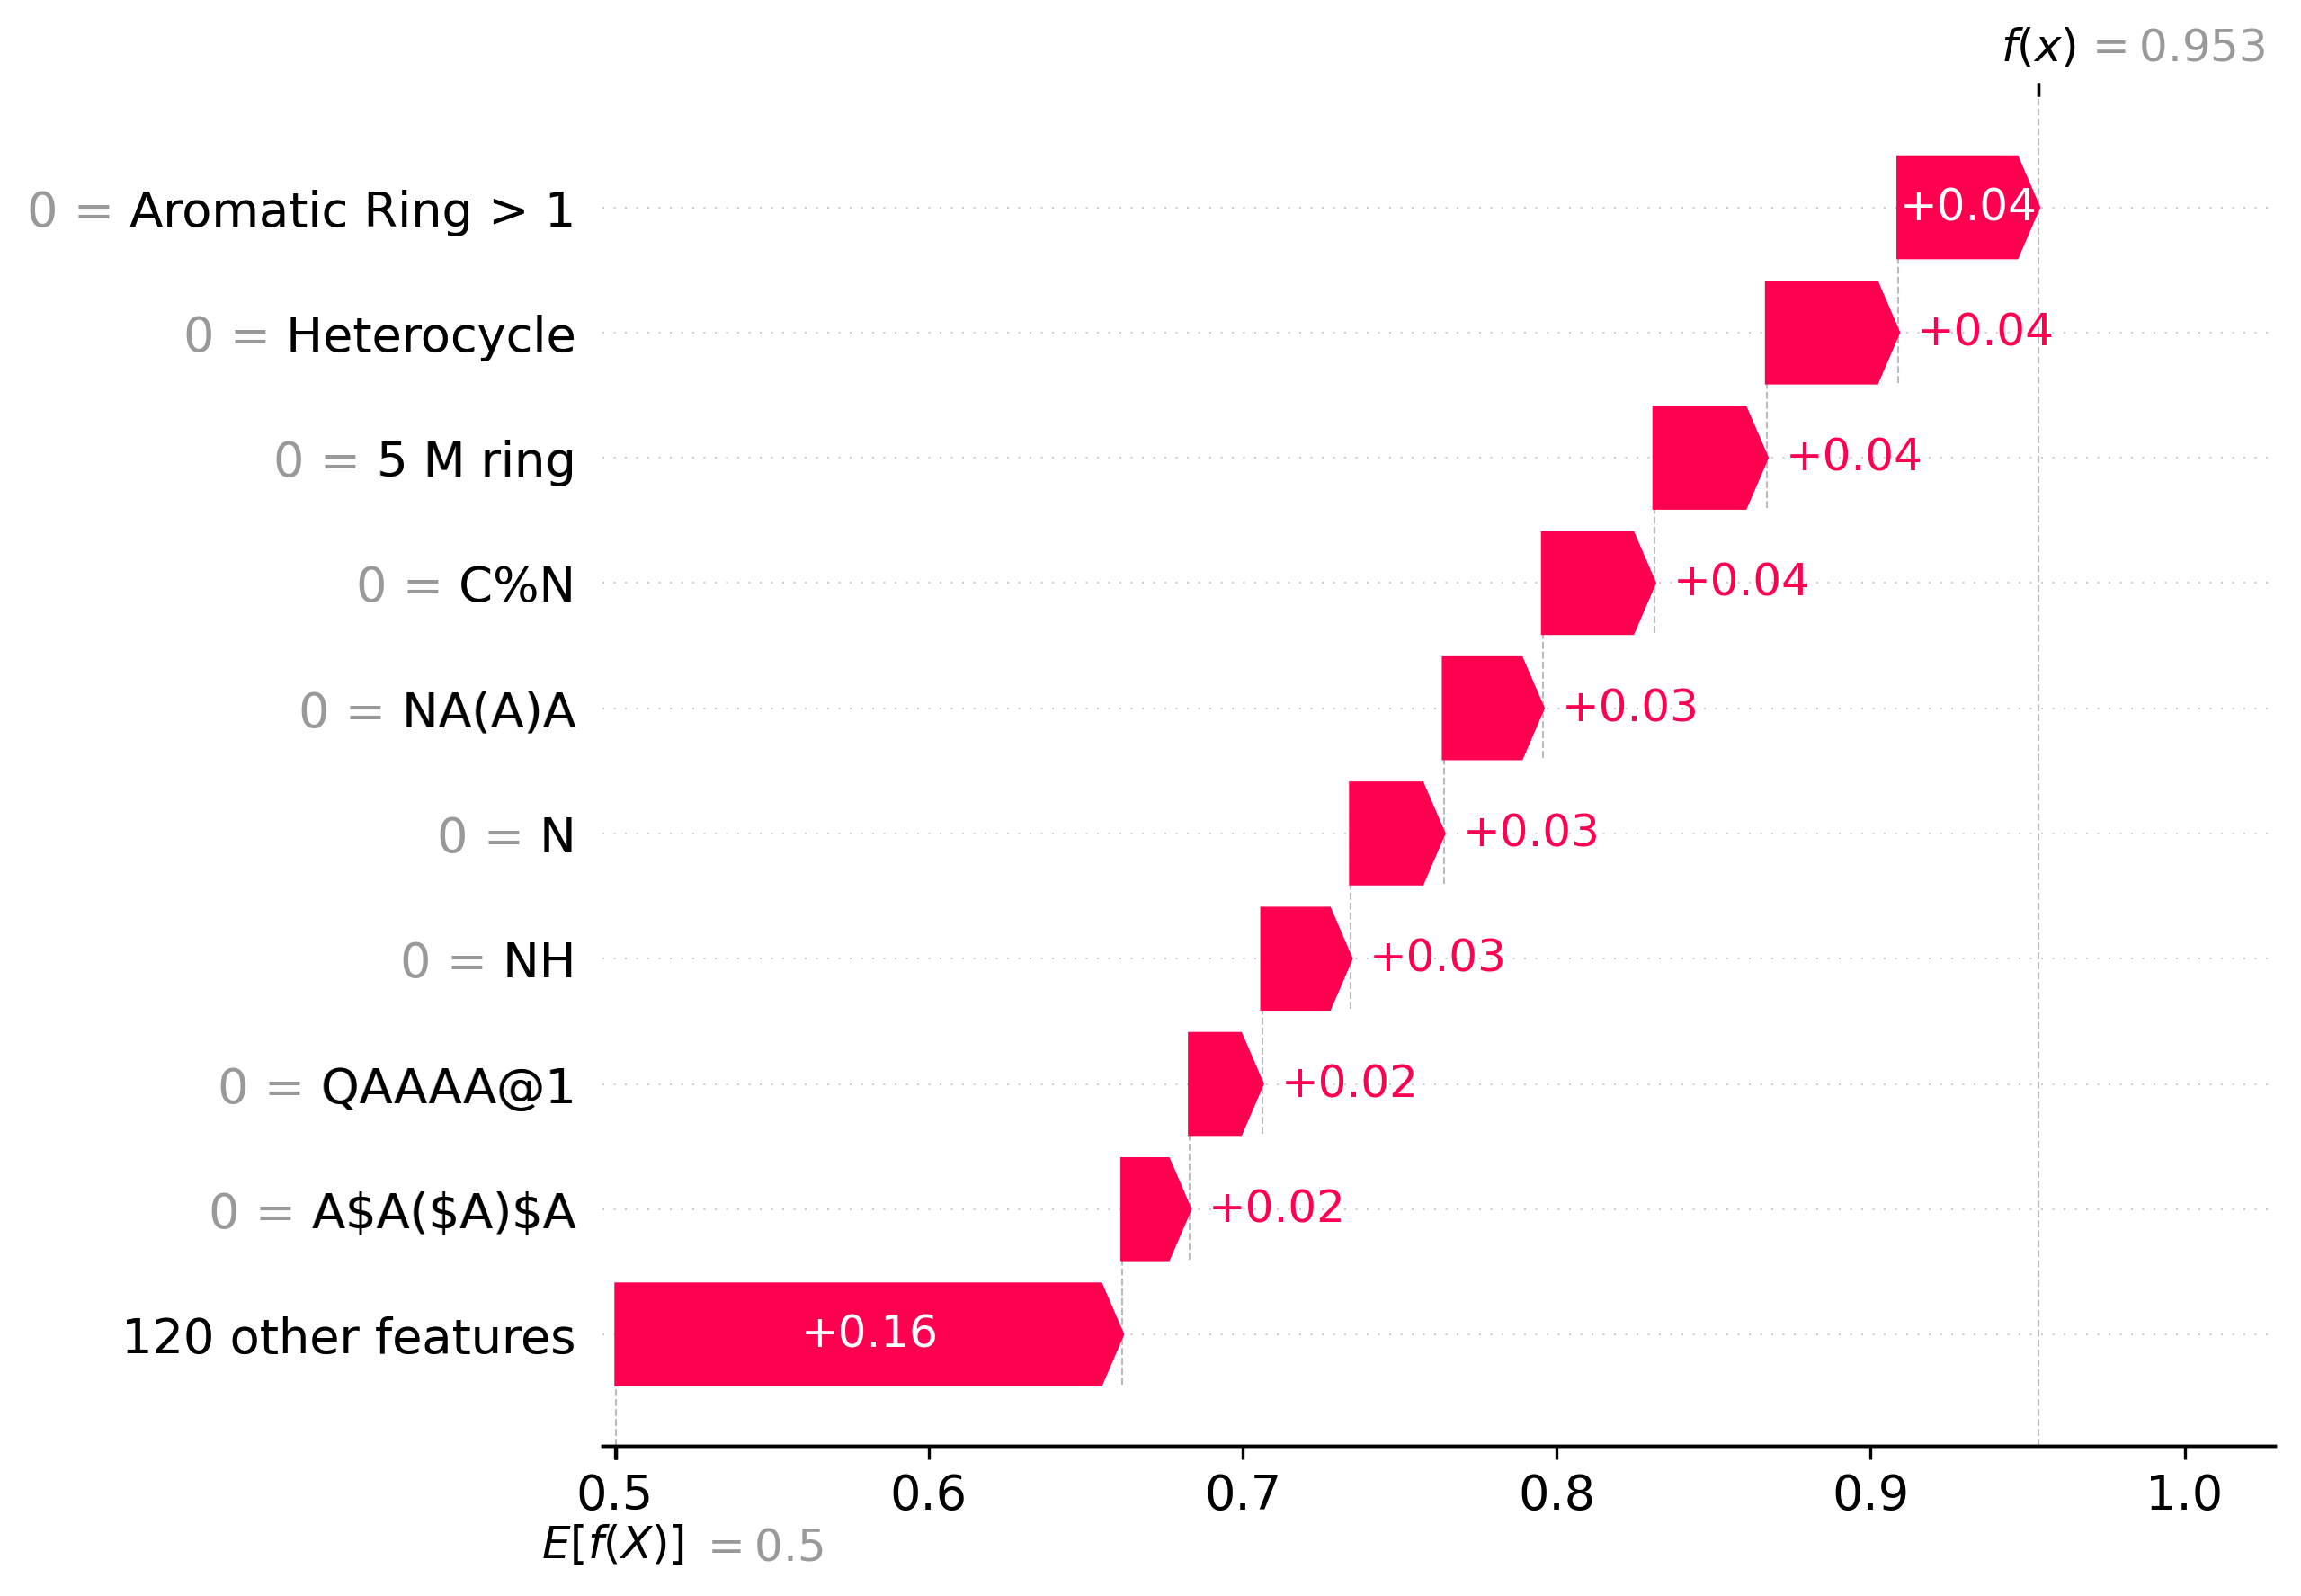

In [66]:
sample_idx = 3
shap_value_sample = shap_values_3[1][sample_idx]

fig = plt.figure()
shap.plots.waterfall(shap.Explanation(values=shap_value_sample, 
                                      base_values=explainer.expected_value[1], 
                                      data=exp_compounds_selected[sample_idx], 
                                      feature_names=result),
                                      show=False)

plt.yticks(fontsize=28)
#plt.savefig("./shap/waterfall.png",dpi=600) 
plt.show()
# plt.clf()

# Linalool

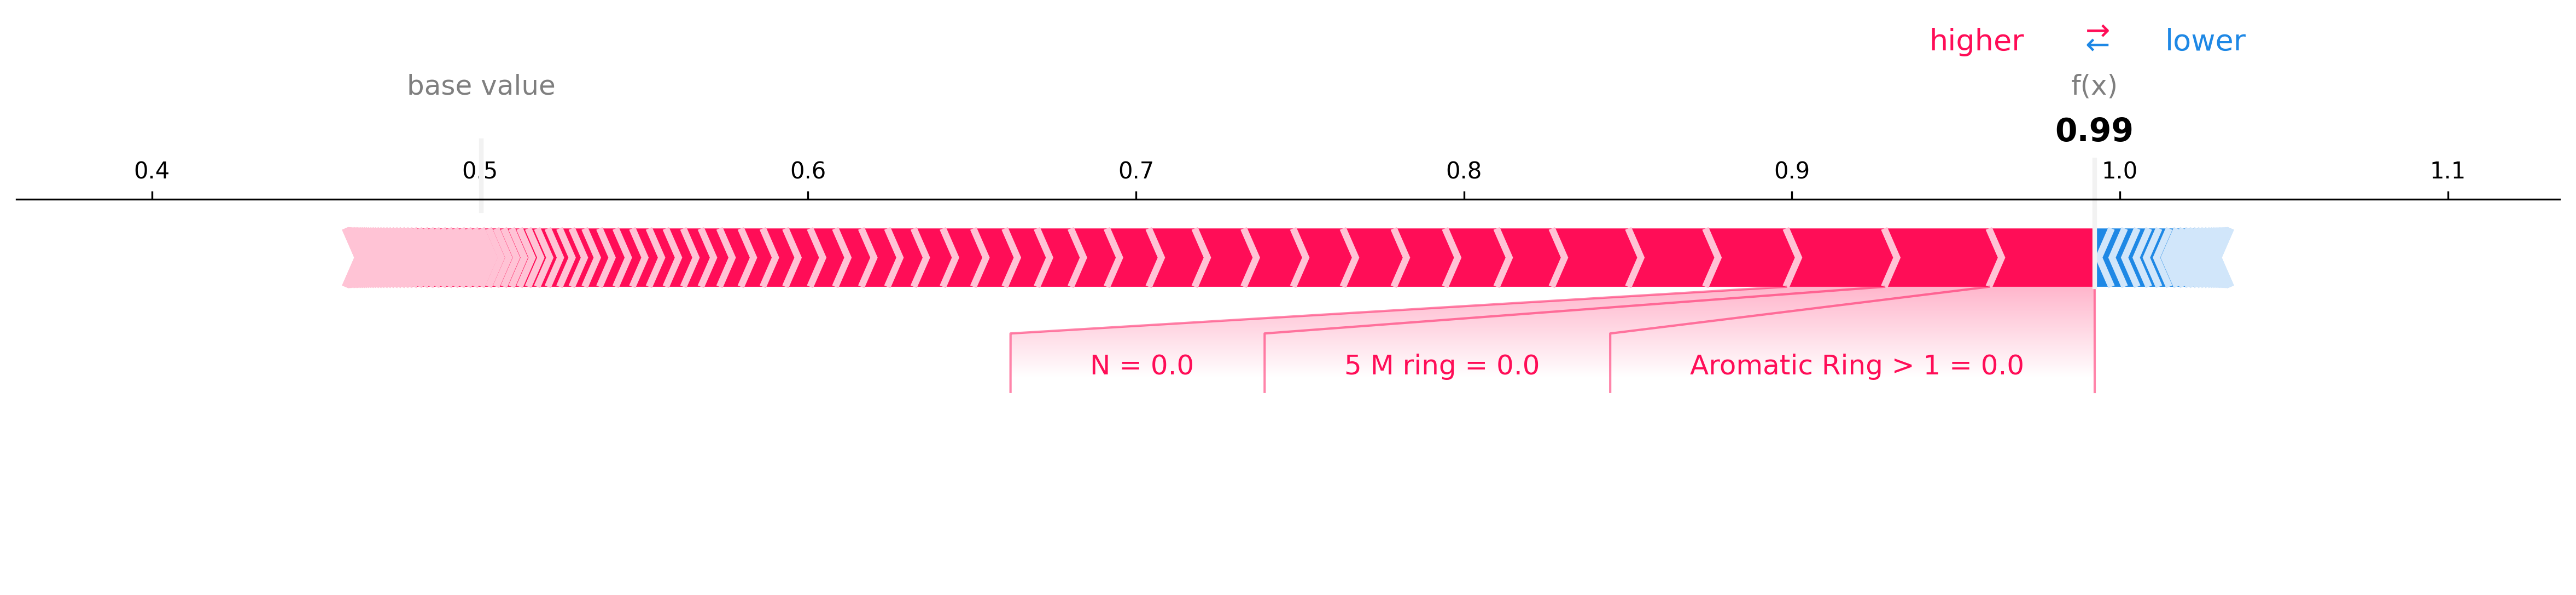

In [28]:
#fig = plt.figure()
sample = 4
shap.force_plot(explainer.expected_value[1],
                shap_values_3[1][sample,:],
                exp_compounds_selected[sample],
                feature_names=result,
                matplotlib=True,
               show = False)
#plt.savefig("./shap/force_plot.png") 
plt.show()
plt.clf()

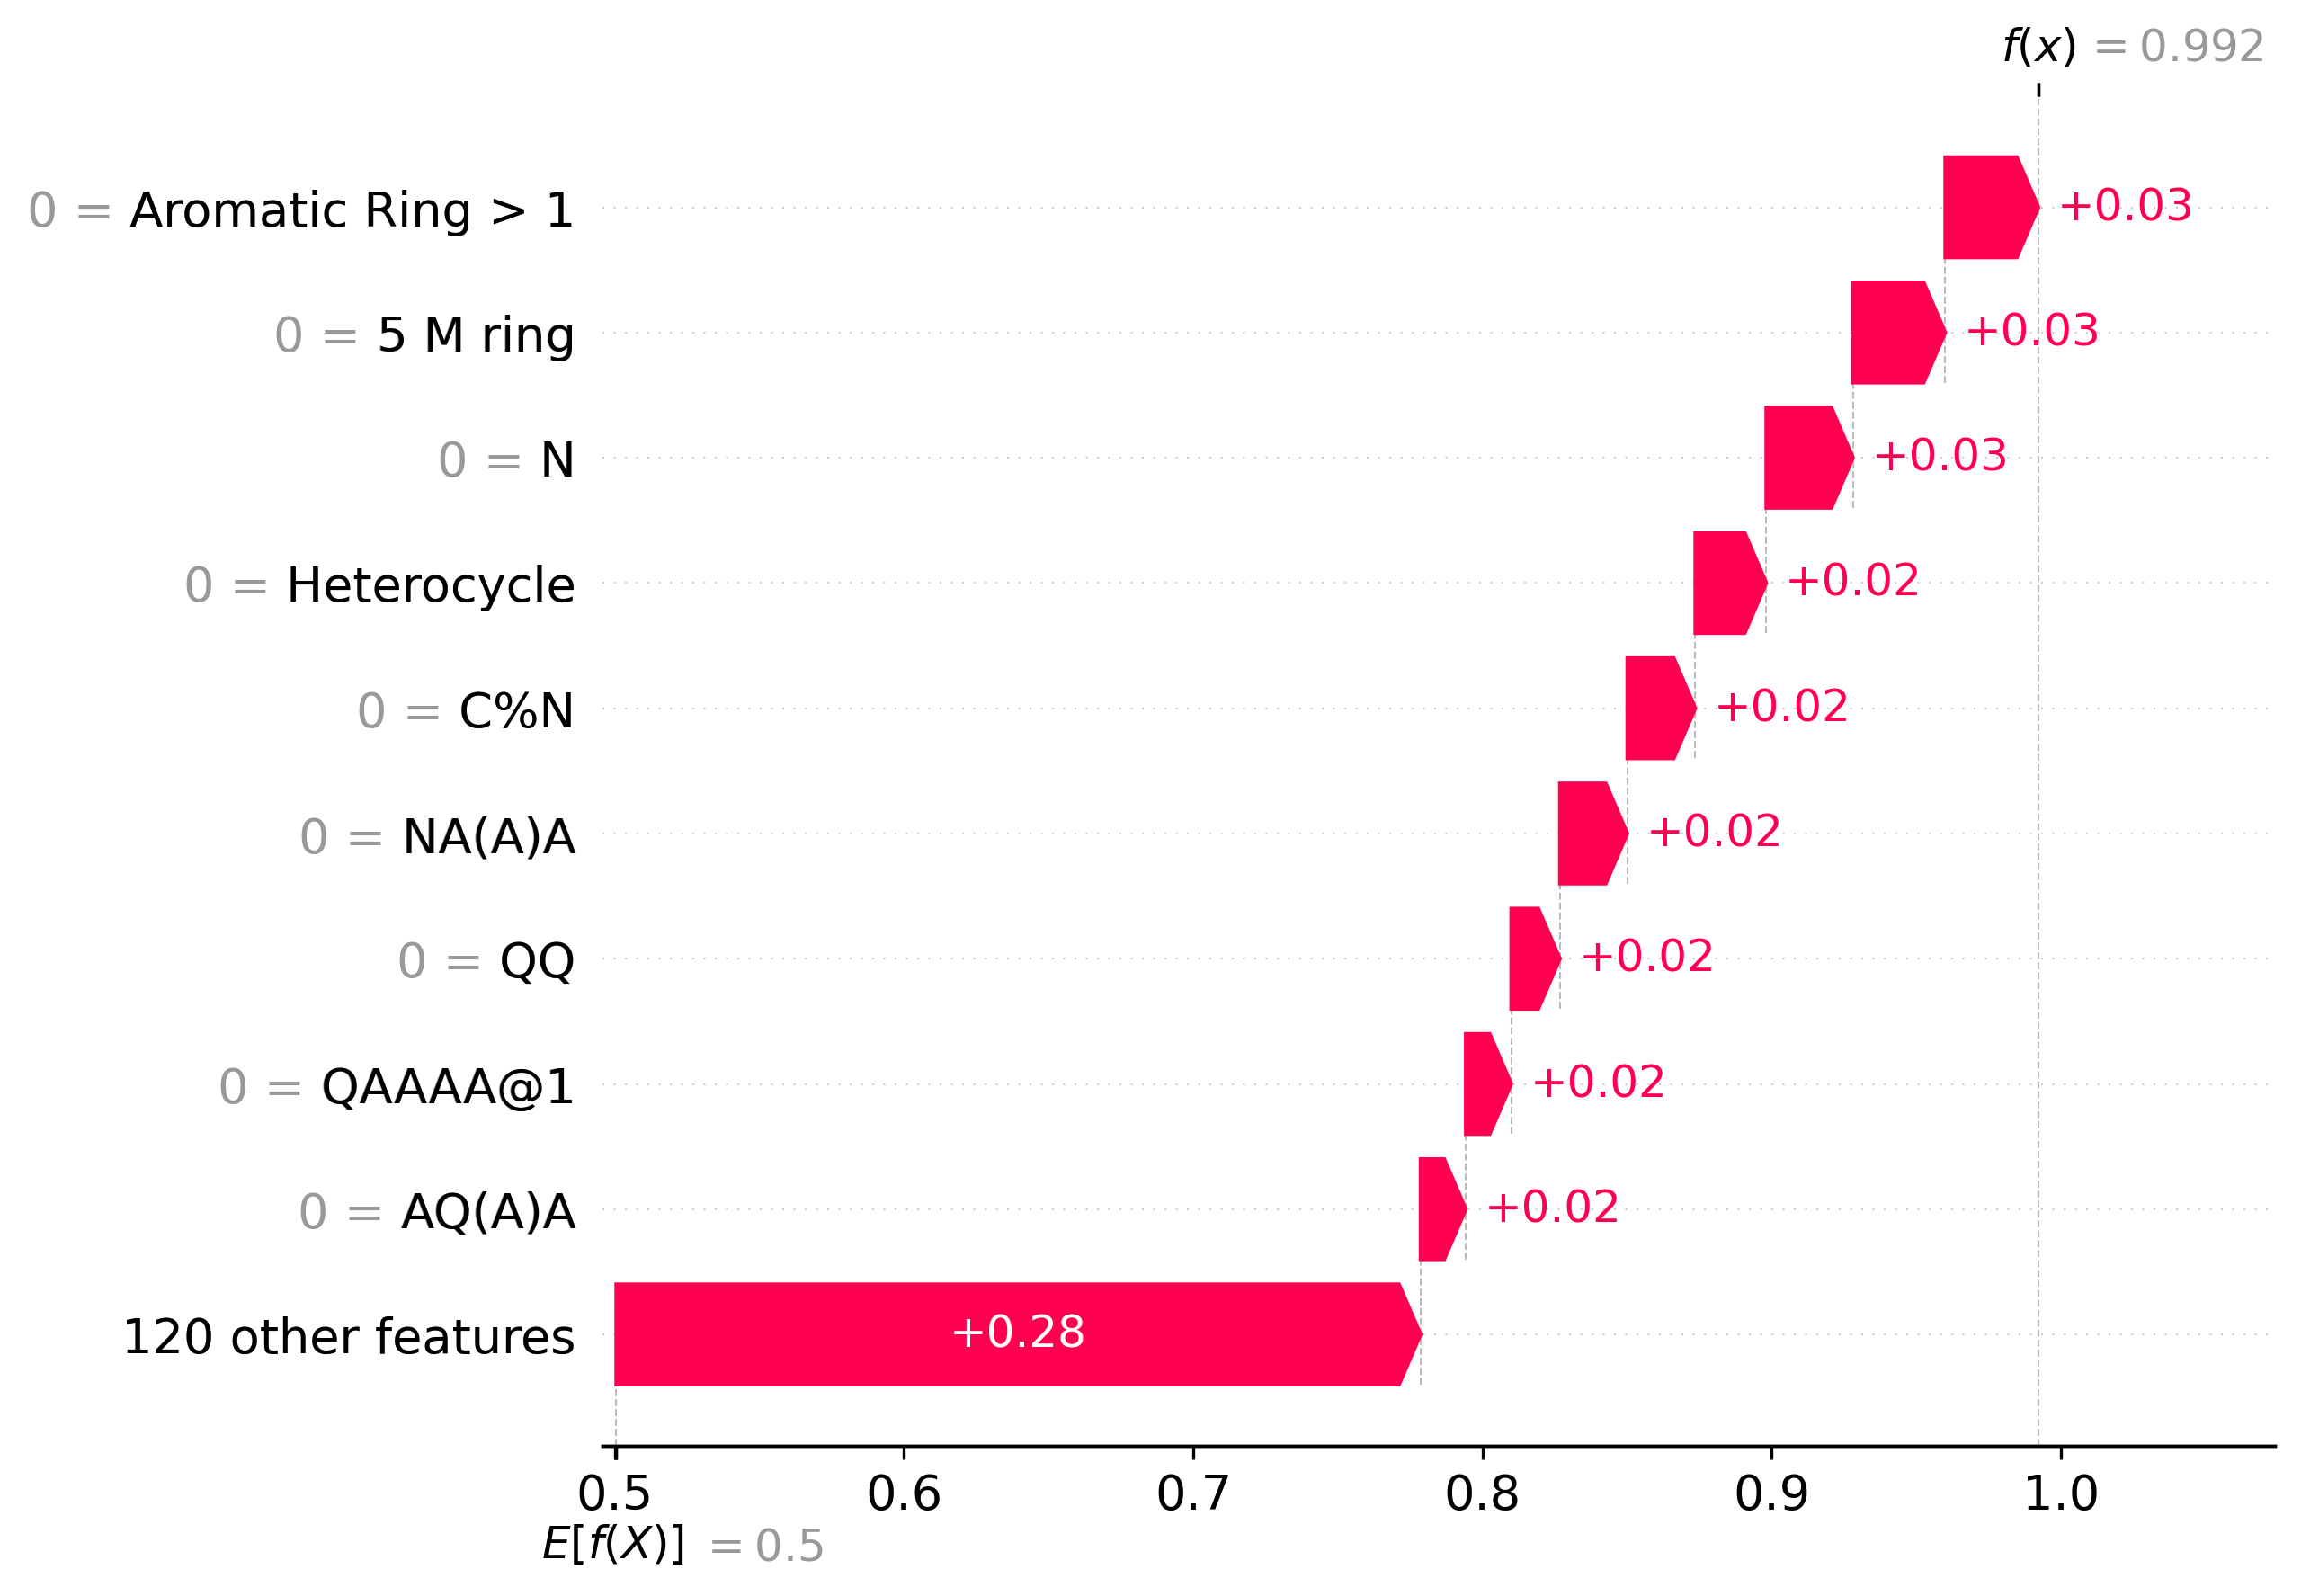

In [27]:
sample_idx = 4
shap_value_sample = shap_values_3[1][sample_idx]

fig = plt.figure()
shap.plots.waterfall(shap.Explanation(values=shap_value_sample, 
                                      base_values=explainer.expected_value[1], 
                                      data=exp_compounds_selected[sample_idx], 
                                      feature_names=result),
                                     #max_display=10,
                                      show=False)

plt.yticks(fontsize=28)
#plt.savefig("./shap/waterfall.png",dpi=600) 
plt.show()
# plt.clf()